# Getting Under and Over Vegas NFL Lines

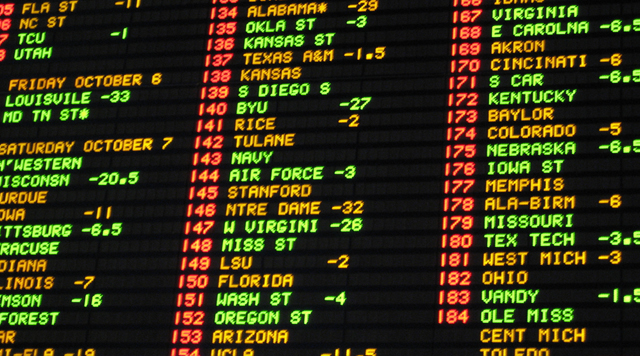

In [1]:
from IPython.display import Image
Image("/Users/matthewnykaza/Documents/Flatiron/Phase_3_Project/NFL_Betting_Data/images/vegas_image.jpeg")

## Overview
For this project I sourced NFL betting, stadiums and teams data from the data website Kaggle. This data includes data going back to the 1978 NFL seasons through this last season. I am tasked with creating a classification model that will assist sports bettors with selecting the over or under in an NFL game. The Over/Under line is the predicted combined score between two teams in a game, to go Over the two teams must combine for greater than that total, and to go Under they must combine for less than that total. I began this project by preprocessing the data, a step that included taking out unnecesary variables, engineering relevant ones from the given data, and performing intelligent decisions as what to do with missing/incomplete data. Once the processing was done I begain to train and edit models using that data, and Sklearn's pipeline function. After some early attempts with base a Logistic Regression model, it was determined that using a tree-based model will likely be the best to get the best scores. The final model used was a Random Forest model, with some hyperparameter tuning, that allowed me to achieve roughly 53% accuracy on my test data. In the future I hope to acquire more information, and continue to tune the model to achieve optimal results. 

## Busines Problem
Vegas has been making money hand over fist from the average person for generations. In today's Vegas they use advanced models that take every bit of information possible in order to create their betting lines. For the average bettor, beating Vegas can feel like an impossible task, but with this project my aim to to make that a reality for more people. The goal will be for anyone to input information about any NFL game and be able to get a accurate prediction over whether to take the Over or Under in that specific matchup. 

In [161]:
import numpy as np
import pandas as pd
import requests
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import geocoder
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import category_encoders as ce
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# The Datasets
For this project I had three datasets
* NFL betting information which included dates, week of schedule, teams, scores, betting lines, weather, stadium names, and playoff information 
* NFL stadium data which had more detailed information about the various stadiums that NFL teams have played at since 1978
* NFL team data which included information about individual teams such as nicknames, conference and division information
The main data that I used was te NFL betting, but I used the stadium information to dig into greater detail about individual stadiums, and I used the NFL teams data to compare conference/divisional matchups, as well as help setup the average scores for each individual team's last 5 games.

The main data that I used was te NFL betting, but I used the stadium information to dig into greater detail about individual stadiums, and I used the NFL teams data to compare conference/divisional matchups, as well as help setup the average scores for each individual team's last 5 games.

### Load in Datasets

In [3]:
nfl_teams = pd.read_csv("//Users/matthewnykaza/Documents/Flatiron/Phase_3_Project/NFL_Betting_Data/Files/nfl_teams.csv")

In [4]:
nfl_teams2 = pd.read_csv("//Users/matthewnykaza/Documents/Flatiron/Phase_3_Project/NFL_Betting_Data/Files/nfl_teams.csv")

In [5]:
nfl_teams.loc[nfl_teams['team_name']== 'Las Vegas Raiders']

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
31,Las Vegas Raiders,Raiders,LVR,RAI,AFC,NaN,AFC,AFC West


In [6]:
nfl_teams.loc[nfl_teams['team_name'] == 'Las Vegas Raiders', 'team_division'] = 'AFC West'

In [7]:
nfl_stadiums = pd.read_csv("//Users/matthewnykaza/Documents/Flatiron/Phase_3_Project/NFL_Betting_Data/Files/nfl_stadiums.csv", encoding='latin1')
nfl_stadiums.head()

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
1,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,NaN,NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN
4,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
nfl_scores = pd.read_csv("//Users/matthewnykaza/Documents/Flatiron/Phase_3_Project/NFL_Betting_Data/Files/spreadspoke_scores.csv.zip")
nfl_scores.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


# Focus on NFL Stadiums Null Values

In [9]:
nfl_stadiums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 15 columns):
stadium_name                    106 non-null object
stadium_location                106 non-null object
stadium_open                    82 non-null float64
stadium_close                   41 non-null float64
stadium_type                    99 non-null object
stadium_address                 94 non-null object
stadium_weather_station_code    93 non-null object
stadium_weather_type            99 non-null object
stadium_capacity                45 non-null object
stadium_surface                 59 non-null object
STATION                         55 non-null object
NAME                            55 non-null object
LATITUDE                        55 non-null float64
LONGITUDE                       55 non-null float64
ELEVATION                       55 non-null float64
dtypes: float64(5), object(10)
memory usage: 12.5+ KB


A few quick thoughts
* We want this to help make sure we have all the data possible for a merge on nfl_scores
* Knowing indoor and outdoor stadiums will be important later on, and we can find that info on the web and do a .loc to update the info
* Once we have the address and stadium type's updated, we can import all latitudes, longitudes and elevation information
* We should also be able to get weather on a given day with this info aswell 

In [10]:
nfl_stadiums[nfl_stadiums['stadium_address'].isnull()]

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
1,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,NaN,NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Dolphin Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Jack Murphy Stadium,"San Diego, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Joe Robbie Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,Mercedes-Benz Stadium,"Atlanta, GA",2017.0,NaN,indoor,NaN,NaN,dome,71000,FieldTurf,NaN,NaN,NaN,NaN,NaN
69,Pro Player Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,Rose Bowl,"Pasadena, CA",NaN,NaN,outdoor,NaN,NaN,moderate,NaN,Grass,NaN,NaN,NaN,NaN,NaN
81,SoFi Stadium,"Inglewood, CA",2020.0,NaN,outdoor,NaN,NaN,warm,70240,Hellas Matrix Turf,NaN,NaN,NaN,NaN,NaN
84,Stanford Stadium,"Palo Alto, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
nfl_stadiums[nfl_stadiums['stadium_type'].isnull()]

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,Dolphin Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,Jack Murphy Stadium,"San Diego, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Joe Robbie Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,Pro Player Stadium,"Miami, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Stanford Stadium,"Palo Alto, CA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Tampa Stadium,"Tampa, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
addresses = ['3333 Al Davis Way, Las Vegas, NV 89118', '1 TIAA Bank Field Dr, Jacksonville, FL 32202', '347 Don Shula Dr, Miami Gardens, FL 33056', '9449 Friars Rd, San Diego, CA 92108', '347 Don Shula Dr, Miami Gardens, FL 33056', '409 Nelson St SW, Atlanta, GA 30313', '347 Don Shula Dr, Miami Gardens, FL 33056', '1001 Rose Bowl Dr, Pasadena, CA 91103', '1000 S. Prairie Avenue, 1001 S. Stadium Drive, Inglewood, CA 90301', '625 Nelson Rd, Stanford, CA 94305', '4201 N Dale Mabry Hwy, Tampa, FL 33607', '1 E 161 St, The Bronx, NY 10451']
types = ['outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor', 'outdoor']

In [13]:
nfl_stadiums.loc[nfl_stadiums['stadium_address'].isnull(), 'stadium_address'] = addresses
nfl_stadiums.loc[nfl_stadiums['stadium_type'].isnull(), 'stadium_type'] = types
nfl_stadiums.head()

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
1,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,outdoor,"1 TIAA Bank Field Dr, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN
4,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
nfl_stadiums['stadium_address'].isnull().sum()

0

In [15]:
nfl_stadiums['stadium_type'].isnull().sum()

0

In [16]:
nfl_stadiums.head(50)

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
1,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,outdoor,"1 TIAA Bank Field Dr, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN
4,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arrowhead Stadium,"Kansas City, MO",1972.0,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.06920,-94.48710,264.9
6,AT&T Stadium,"Arlington, TX",2009.0,NaN,retractable,"1 AT&T Way, Arlington, TX 76011",76011,dome,"80,000",FieldTurf,USC00410337,"ARLINGTON SIX FLAGS, TX US",32.75720,-97.07360,163.4
7,Atlanta-Fulton County Stadium,"Atlanta, GA",1966.0,1991.0,outdoor,"521 Capitol Avenue SE, Atlanta, Georgia 30312",30312,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Balboa Stadium,"San Diego, CA",NaN,NaN,outdoor,"Balboa Stadium, San Diego, CA 92101",92101,warm,NaN,Grass,NaN,NaN,NaN,NaN,NaN
9,Bank of America Stadium,"Charlotte, NC",1996.0,2016.0,outdoor,"800 S Mint St, Charlotte, NC 28202",28202,moderate,"73,778",Grass,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22360,-80.95520,221.9


In [17]:
nfl_stadiums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 15 columns):
stadium_name                    106 non-null object
stadium_location                106 non-null object
stadium_open                    82 non-null float64
stadium_close                   41 non-null float64
stadium_type                    106 non-null object
stadium_address                 106 non-null object
stadium_weather_station_code    93 non-null object
stadium_weather_type            99 non-null object
stadium_capacity                45 non-null object
stadium_surface                 59 non-null object
STATION                         55 non-null object
NAME                            55 non-null object
LATITUDE                        55 non-null float64
LONGITUDE                       55 non-null float64
ELEVATION                       55 non-null float64
dtypes: float64(5), object(10)
memory usage: 12.5+ KB


Now let's update all latitudes, longitudes and elevation

In [18]:
locator = Nominatim(user_agent='myGeocoder')

In [19]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
nfl_stadiums['location'] = nfl_stadiums['stadium_address'].apply(geocode)
nfl_stadiums['point'] = nfl_stadiums['location'].apply(lambda loc: tuple(loc.point) if loc else None)
nfl_stadiums[['latitude', 'longitude', 'elevation']] = pd.DataFrame(nfl_stadiums['point'].tolist(), index=nfl_stadiums.index)

In [20]:
nfl_stadiums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 20 columns):
stadium_name                    106 non-null object
stadium_location                106 non-null object
stadium_open                    82 non-null float64
stadium_close                   41 non-null float64
stadium_type                    106 non-null object
stadium_address                 106 non-null object
stadium_weather_station_code    93 non-null object
stadium_weather_type            99 non-null object
stadium_capacity                45 non-null object
stadium_surface                 59 non-null object
STATION                         55 non-null object
NAME                            55 non-null object
LATITUDE                        55 non-null float64
LONGITUDE                       55 non-null float64
ELEVATION                       55 non-null float64
location                        82 non-null object
point                           82 non-null object
latitude           

In [21]:
nfl_stadiums.head(50)

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,location,point,latitude,longitude,elevation
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN,"(Alamodome, 100, Montana Street, Hemisfair, Sa...","(29.4168923, -98.47889487569296, 0.0)",29.416892,-98.478895,0.0
1,Allegiant Stadium,"Paradise, NV",2020.0,NaN,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,dome,65000,Grass,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN
2,Alltel Stadium,"Jacksonville, FL",NaN,NaN,outdoor,"1 TIAA Bank Field Dr, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN
3,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN
4,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(East Gene Autry Way, Anaheim Resort District,...","(33.7997114, -117.8893958, 0.0)",33.799711,-117.889396,0.0
5,Arrowhead Stadium,"Kansas City, MO",1972.0,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.06920,-94.48710,264.9,"(Arrowhead Stadium, 1, Arrowhead Drive, Kansas...","(39.0489387, -94.48398375192306, 0.0)",39.048939,-94.483984,0.0
6,AT&T Stadium,"Arlington, TX",2009.0,NaN,retractable,"1 AT&T Way, Arlington, TX 76011",76011,dome,"80,000",FieldTurf,USC00410337,"ARLINGTON SIX FLAGS, TX US",32.75720,-97.07360,163.4,"(AT&T Way, Arlington, Tarrant County, Texas, 7...","(32.7529534, -97.087837, 0.0)",32.752953,-97.087837,0.0
7,Atlanta-Fulton County Stadium,"Atlanta, GA",1966.0,1991.0,outdoor,"521 Capitol Avenue SE, Atlanta, Georgia 30312",30312,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(521, Capitol Avenue Southeast, Summerhill, At...","(33.741551135213975, -84.38789150855104, 0.0)",33.741551,-84.387892,0.0
8,Balboa Stadium,"San Diego, CA",NaN,NaN,outdoor,"Balboa Stadium, San Diego, CA 92101",92101,warm,NaN,Grass,NaN,NaN,NaN,NaN,NaN,"(Balboa Stadium, Russ Boulevard, East Village,...","(32.7207107, -117.15042, 0.0)",32.720711,-117.150420,0.0
9,Bank of America Stadium,"Charlotte, NC",1996.0,2016.0,outdoor,"800 S Mint St, Charlotte, NC 28202",28202,moderate,"73,778",Grass,USW00013881,"CHARLOTTE DOUGLAS AIRPORT, NC US",35.22360,-80.95520,221.9,"(Bank of America Stadium, 800, South Mint Stre...","(35.225737, -80.8527666409835, 0.0)",35.225737,-80.852767,0.0


* So we didn't get all of the lats and longs we wanted, but we certainly have more than before, so we'll keep them in for now and see what happens after the merge
* But for the lats and longs we did get, they look to be accurate to the existing data
* Elevations all 0, so that is dissapointing, but we will move on

Remove unwanted columns

In [22]:
nfl_stadiums = nfl_stadiums.drop(columns=['stadium_location', 'stadium_open', 'stadium_close', 'stadium_weather_type', 'stadium_capacity', 'stadium_surface', 'LATITUDE', 'LONGITUDE', 'elevation', 'location', 'point'])
nfl_stadiums.head()

,stadium_name,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
0,Alamo Dome,indoor,"100 Montana St, San Antonio, TX 78203",78203,NaN,NaN,NaN,29.416892,-98.478895
1,Allegiant Stadium,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,outdoor,"1 TIAA Bank Field Dr, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,NaN,NaN
3,Alumni Stadium,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,NaN,NaN,NaN,NaN,NaN
4,Anaheim Stadium,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,NaN,NaN,NaN,33.799711,-117.889396


## Reasoning for drops
* Location is worse than address
* open and close really don't matter at all for this
* Weather type is very arbitrary
* capacity doesn't really matter for what we are trying to do
* Surface has too many nulls, and there isn't enough time to look up each stadium
* LATITUDE and LONGITUDE were redunant with the ones we created
* elevation was useless, all 0

In [23]:
nfl_stadiums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
stadium_name                    106 non-null object
stadium_type                    106 non-null object
stadium_address                 106 non-null object
stadium_weather_station_code    93 non-null object
STATION                         55 non-null object
NAME                            55 non-null object
ELEVATION                       55 non-null float64
latitude                        82 non-null float64
longitude                       82 non-null float64
dtypes: float64(3), object(6)
memory usage: 7.6+ KB


# Move on to nfl_scores data

In [24]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12947 entries, 0 to 12946
Data columns (total 17 columns):
schedule_date          12947 non-null object
schedule_season        12947 non-null int64
schedule_week          12947 non-null object
schedule_playoff       12947 non-null bool
team_home              12947 non-null object
score_home             12946 non-null float64
score_away             12946 non-null float64
team_away              12947 non-null object
team_favorite_id       10468 non-null object
spread_favorite        10468 non-null float64
over_under_line        10458 non-null object
stadium                12947 non-null object
stadium_neutral        12947 non-null bool
weather_temperature    12008 non-null float64
weather_wind_mph       12008 non-null float64
weather_humidity       8388 non-null object
weather_detail         2711 non-null object
dtypes: bool(2), float64(5), int64(1), object(9)
memory usage: 1.5+ MB


In [25]:
#Make schedule a datetime 
nfl_scores['schedule_date'] = pd.to_datetime(nfl_scores['schedule_date'])

* Considering this whole project is about trying to get a classifier that can pick overs/unders we need all that data we can, any without that data will be removed

In [26]:
nfl_scores = nfl_scores[nfl_scores['spread_favorite'].notna()]
nfl_scores = nfl_scores[nfl_scores['over_under_line'].notna()]

In [27]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 350 to 12946
Data columns (total 17 columns):
schedule_date          10458 non-null datetime64[ns]
schedule_season        10458 non-null int64
schedule_week          10458 non-null object
schedule_playoff       10458 non-null bool
team_home              10458 non-null object
score_home             10457 non-null float64
score_away             10457 non-null float64
team_away              10458 non-null object
team_favorite_id       10458 non-null object
spread_favorite        10458 non-null float64
over_under_line        10458 non-null object
stadium                10458 non-null object
stadium_neutral        10458 non-null bool
weather_temperature    9749 non-null float64
weather_wind_mph       9749 non-null float64
weather_humidity       6289 non-null object
weather_detail         2553 non-null object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 1.3+ MB


In [28]:
nfl_scores.head(100)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
350,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43,Orange Bowl,True,60.0,12.0,74,NaN
538,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40,Orange Bowl,True,66.0,12.0,80,NaN
727,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,84,NaN
916,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36,Orange Bowl,True,59.0,11.0,60,NaN
1105,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34,Tulane Stadium,True,34.0,18.0,40,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,1979-10-08,1979,6,False,Oakland Raiders,13.0,3.0,Miami Dolphins,MIA,-1.0,39,Oakland Coliseum,False,63.0,12.0,78,NaN
2585,1979-10-14,1979,7,False,Baltimore Colts,16.0,28.0,Houston Oilers,TEN,-6.0,36,Memorial Stadium (Baltimore),False,46.0,13.0,62,NaN
2586,1979-10-14,1979,7,False,Chicago Bears,7.0,27.0,New England Patriots,NE,-4.0,37,Soldier Field,False,45.0,9.0,47,NaN
2587,1979-10-14,1979,7,False,Cincinnati Bengals,34.0,10.0,Pittsburgh Steelers,PIT,-10.0,39,Cinergy Field,False,40.0,7.0,60,NaN


* Only the superbowls before 1979 have the betting data, so we will remove those

In [29]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 350 to 12946
Data columns (total 17 columns):
schedule_date          10458 non-null datetime64[ns]
schedule_season        10458 non-null int64
schedule_week          10458 non-null object
schedule_playoff       10458 non-null bool
team_home              10458 non-null object
score_home             10457 non-null float64
score_away             10457 non-null float64
team_away              10458 non-null object
team_favorite_id       10458 non-null object
spread_favorite        10458 non-null float64
over_under_line        10458 non-null object
stadium                10458 non-null object
stadium_neutral        10458 non-null bool
weather_temperature    9749 non-null float64
weather_wind_mph       9749 non-null float64
weather_humidity       6289 non-null object
weather_detail         2553 non-null object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 1.3+ MB


In [30]:
nfl_scores[nfl_scores['score_away'].isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
12946,2021-02-07,2020,Superbowl,True,Tampa Bay Buccaneers,NaN,NaN,Kansas City Chiefs,KC,-3.0,56,Raymond James Stadium,False,NaN,NaN,NaN,NaN


* The only data without a score_home and score_away is the last superbowl, since this game happened this will be easy enough to input

In [31]:
nfl_scores.loc[nfl_scores['score_home'].isnull(), 'score_home'] = 31.0
nfl_scores.loc[nfl_scores['score_away'].isnull(), 'score_away'] = 9.0


In [32]:
nfl_scores[nfl_scores['score_away'].isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail


In [33]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 350 to 12946
Data columns (total 17 columns):
schedule_date          10458 non-null datetime64[ns]
schedule_season        10458 non-null int64
schedule_week          10458 non-null object
schedule_playoff       10458 non-null bool
team_home              10458 non-null object
score_home             10458 non-null float64
score_away             10458 non-null float64
team_away              10458 non-null object
team_favorite_id       10458 non-null object
spread_favorite        10458 non-null float64
over_under_line        10458 non-null object
stadium                10458 non-null object
stadium_neutral        10458 non-null bool
weather_temperature    9749 non-null float64
weather_wind_mph       9749 non-null float64
weather_humidity       6289 non-null object
weather_detail         2553 non-null object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(8)
memory usage: 1.3+ MB


* Weather detail is mostly unfilled, and mostly arbitrary, we're just gonna drop that
* I may have a different idea for adding it back in

In [34]:
nfl_scores = nfl_scores.drop(columns='weather_detail')

In [35]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10458 entries, 350 to 12946
Data columns (total 16 columns):
schedule_date          10458 non-null datetime64[ns]
schedule_season        10458 non-null int64
schedule_week          10458 non-null object
schedule_playoff       10458 non-null bool
team_home              10458 non-null object
score_home             10458 non-null float64
score_away             10458 non-null float64
team_away              10458 non-null object
team_favorite_id       10458 non-null object
spread_favorite        10458 non-null float64
over_under_line        10458 non-null object
stadium                10458 non-null object
stadium_neutral        10458 non-null bool
weather_temperature    9749 non-null float64
weather_wind_mph       9749 non-null float64
weather_humidity       6289 non-null object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(7)
memory usage: 1.2+ MB


* As far as the rest of the nulls, I want to wait until we have merged with the stadium data, I have an idea that a lot of that has to due with being in a indoor stadium
* I have concerns about over_under_line being an object

In [36]:
nfl_scores[nfl_scores['over_under_line'].str.contains(' ')]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity
2725,1979-12-23,1979,Wildcard,True,Houston Oilers,13.0,7.0,Denver Broncos,TEN,-7.0,,Houston Astrodome,False,72.0,0.0,NaN
2726,1979-12-23,1979,Wildcard,True,Philadelphia Eagles,27.0,17.0,Chicago Bears,PHI,-6.5,,Veterans Stadium,False,NaN,NaN,NaN
2727,1979-12-29,1979,Division,True,San Diego Chargers,14.0,17.0,Houston Oilers,LAC,-8.0,,Qualcomm Stadium,False,NaN,NaN,NaN
2728,1979-12-29,1979,Division,True,Tampa Bay Buccaneers,24.0,17.0,Philadelphia Eagles,PHI,-4.5,,Houlihan's Stadium,False,NaN,NaN,NaN
2729,1979-12-30,1979,Division,True,Dallas Cowboys,19.0,21.0,Los Angeles Rams,DAL,-8.5,,Texas Stadium,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,1986-01-04,1985,Division,True,Miami Dolphins,24.0,21.0,Cleveland Browns,MIA,-10.5,,Orange Bowl,False,NaN,NaN,NaN
4035,1986-01-05,1985,Division,True,Chicago Bears,21.0,0.0,New York Giants,CHI,-9.0,,Soldier Field,False,NaN,NaN,NaN
4036,1986-01-05,1985,Division,True,Los Angeles Raiders,20.0,27.0,New England Patriots,LVR,-5.5,,Los Angeles Memorial Coliseum,False,NaN,NaN,NaN
4037,1986-01-12,1985,Conference,True,Chicago Bears,24.0,0.0,Los Angeles Rams,CHI,-10.5,,Soldier Field,False,NaN,NaN,NaN


* Looks like we have 62 rows of data in the over_under_lines that are strings, for simplicity I am simply going to remove them

In [37]:
nfl_scores = nfl_scores[~nfl_scores['over_under_line'].str.contains(' ')]
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 350 to 12946
Data columns (total 16 columns):
schedule_date          10396 non-null datetime64[ns]
schedule_season        10396 non-null int64
schedule_week          10396 non-null object
schedule_playoff       10396 non-null bool
team_home              10396 non-null object
score_home             10396 non-null float64
score_away             10396 non-null float64
team_away              10396 non-null object
team_favorite_id       10396 non-null object
spread_favorite        10396 non-null float64
over_under_line        10396 non-null object
stadium                10396 non-null object
stadium_neutral        10396 non-null bool
weather_temperature    9745 non-null float64
weather_wind_mph       9745 non-null float64
weather_humidity       6289 non-null object
dtypes: bool(2), datetime64[ns](1), float64(5), int64(1), object(7)
memory usage: 1.2+ MB


In [38]:
convert = {'over_under_line': 'float'}
nfl_scores = nfl_scores.astype(convert)

In [39]:
nfl_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 350 to 12946
Data columns (total 16 columns):
schedule_date          10396 non-null datetime64[ns]
schedule_season        10396 non-null int64
schedule_week          10396 non-null object
schedule_playoff       10396 non-null bool
team_home              10396 non-null object
score_home             10396 non-null float64
score_away             10396 non-null float64
team_away              10396 non-null object
team_favorite_id       10396 non-null object
spread_favorite        10396 non-null float64
over_under_line        10396 non-null float64
stadium                10396 non-null object
stadium_neutral        10396 non-null bool
weather_temperature    9745 non-null float64
weather_wind_mph       9745 non-null float64
weather_humidity       6289 non-null object
dtypes: bool(2), datetime64[ns](1), float64(6), int64(1), object(6)
memory usage: 1.2+ MB


In [40]:
nfl_scores.describe()

,schedule_season,score_home,score_away,spread_favorite,over_under_line,weather_temperature,weather_wind_mph
count,10396.000000,10396.000000,10396.000000,10396.000000,10396.000000,9745.000000,9745.000000
mean,2000.489708,22.707291,20.034340,-5.377982,42.093565,59.894202,7.268958
std,11.961715,10.374221,10.082921,3.431925,4.777090,15.411954,5.719802
min,1967.000000,0.000000,0.000000,-26.500000,28.000000,-6.000000,0.000000
25%,1990.000000,16.000000,13.000000,-7.000000,38.500000,50.000000,1.000000
50%,2001.000000,23.000000,20.000000,-4.500000,42.000000,64.000000,7.000000
75%,2011.000000,30.000000,27.000000,-3.000000,45.000000,72.000000,11.000000
max,2020.000000,62.000000,59.000000,0.000000,63.500000,97.000000,40.000000


# Begin Merge of nfl_stadiums and nfl_scores

In [41]:
# Need to make stadium_name equivalent to what it is (stadium) for the nfl_scores df
nfl_stadiums = nfl_stadiums.rename(columns={'stadium_name': 'stadium'})
nfl_stadiums.head()

,stadium,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
0,Alamo Dome,indoor,"100 Montana St, San Antonio, TX 78203",78203,NaN,NaN,NaN,29.416892,-98.478895
1,Allegiant Stadium,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,NaN,NaN,NaN,NaN,NaN
2,Alltel Stadium,outdoor,"1 TIAA Bank Field Dr, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,NaN,NaN
3,Alumni Stadium,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,NaN,NaN,NaN,NaN,NaN
4,Anaheim Stadium,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,NaN,NaN,NaN,33.799711,-117.889396


In [42]:
nfl = pd.merge(nfl_scores, nfl_stadiums, on='stadium', how='left')
nfl.head(50)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,...,12.0,74,outdoor,"1501 NW 3rd St, Miami, FL 33125",33125,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",8.8,25.776346,-80.219909
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,...,12.0,80,outdoor,"1501 NW 3rd St, Miami, FL 33125",33125,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",8.8,25.776346,-80.219909
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,...,14.0,84,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,...,11.0,60,outdoor,"1501 NW 3rd St, Miami, FL 33125",33125,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",8.8,25.776346,-80.219909
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,...,18.0,40,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
5,1973-01-14,1972,Superbowl,True,Miami Dolphins,14.0,7.0,Washington Redskins,MIA,-1.0,...,7.0,53,outdoor,"3911 S Figueroa St, Los Angeles, CA 90037",90037,USW00023174,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,33.975740,-118.282689
6,1974-01-13,1973,Superbowl,True,Miami Dolphins,24.0,7.0,Minnesota Vikings,MIA,-6.5,...,7.0,81,outdoor,"2176 University Boulevard, Houston, TX 77251",77251,NaN,NaN,NaN,NaN,NaN
7,1975-01-12,1974,Superbowl,True,Minnesota Vikings,6.0,16.0,Pittsburgh Steelers,PIT,-3.0,...,17.0,72,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
8,1976-01-18,1975,Superbowl,True,Dallas Cowboys,17.0,21.0,Pittsburgh Steelers,PIT,-7.0,...,18.0,44,outdoor,"1501 NW 3rd St, Miami, FL 33125",33125,USW00012839,"MIAMI INTERNATIONAL AIRPORT, FL US",8.8,25.776346,-80.219909
9,1977-01-09,1976,Superbowl,True,Minnesota Vikings,14.0,32.0,Oakland Raiders,LVR,-4.0,...,6.0,59,outdoor,"1001 Rose Bowl Dr, Pasadena, CA 91103",NaN,NaN,NaN,NaN,34.163214,-118.165789


In [43]:
nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9745 non-null float64
weather_humidity                6289 non-null object
stadium_type         

Evaluate those pesky stadiums without addresses/types

In [44]:
#Seperate the areas of data without info se we can get a easier look at them
null_stad = nfl[nfl['stadium_address'].isnull()]

In [45]:
null_stad['stadium'].value_counts()

FedEx Field                  196
TIAA Bank Field               21
Tottenham Hotspur Stadium      2
Tottenham Stadium              1
Name: stadium, dtype: int64

Mostly looks like it effects a few stadiums, we should be able to add in the addresses and types pretty easily

In [46]:
null_stad.loc[null_stad['stadium'] == 'FedEx Field', 'stadium_address'] = '1600 Fedex Way, Landover, MD 20785'
null_stad.loc[null_stad['stadium'] == 'Tottenham Hotspur Stadium', 'stadium'] = 'Tottenham Stadium'
null_stad.loc[null_stad['stadium'] == 'Tottenham Stadium', 'stadium_address'] = '782 High Rd, Tottenham, London N17 0BX, United Kingdom'
null_stad.loc[null_stad['stadium'] == 'TIAA Bank Field', 'stadium_address'] = '410 Franklin St, Jacksonville, FL 32202'
null_stad.head(50)


/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
4083,1997-09-14,1997,3,False,Washington Redskins,19.0,13.0,Arizona Cardinals,WAS,-8.0,...,7.0,65,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4109,1997-09-28,1997,5,False,Washington Redskins,24.0,12.0,Jacksonville Jaguars,WAS,-1.0,...,14.0,85,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4135,1997-10-13,1997,7,False,Washington Redskins,21.0,16.0,Dallas Cowboys,DAL,-3.0,...,8.0,72,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4160,1997-10-26,1997,9,False,Washington Redskins,17.0,20.0,Baltimore Ravens,WAS,-6.5,...,11.0,86,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4190,1997-11-09,1997,11,False,Washington Redskins,30.0,7.0,Detroit Lions,WAS,-4.0,...,15.0,85,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4220,1997-11-23,1997,13,False,Washington Redskins,7.0,7.0,New York Giants,WAS,-5.5,...,5.0,90,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4235,1997-11-30,1997,14,False,Washington Redskins,20.0,23.0,St. Louis Rams,WAS,-8.5,...,6.0,82,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4280,1997-12-21,1997,17,False,Washington Redskins,35.0,32.0,Philadelphia Eagles,WAS,-5.5,...,10.0,58,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4322,1998-09-14,1998,2,False,Washington Redskins,10.0,45.0,San Francisco 49ers,SF,-4.5,...,10.0,69,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN
4347,1998-09-27,1998,4,False,Washington Redskins,16.0,38.0,Denver Broncos,DEN,-6.5,...,12.0,60,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
null_stad.loc[null_stad['stadium'] == 'Tottenham Stadium']

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
9682,2018-10-14,2018,6,False,Oakland Raiders,3.0,27.0,Seattle Seahawks,SEA,-3.0,...,12.0,NaN,NaN,"782 High Rd, Tottenham, London N17 0BX, United...",NaN,NaN,NaN,NaN,NaN,NaN
9932,2019-10-06,2019,5,False,Oakland Raiders,24.0,21.0,Chicago Bears,CHI,-6.5,...,NaN,NaN,NaN,"782 High Rd, Tottenham, London N17 0BX, United...",NaN,NaN,NaN,NaN,NaN,NaN
9950,2019-10-13,2019,6,False,Tampa Bay Buccaneers,26.0,37.0,Carolina Panthers,CAR,-2.0,...,NaN,NaN,NaN,"782 High Rd, Tottenham, London N17 0BX, United...",NaN,NaN,NaN,NaN,NaN,NaN


Let's try that geopy lat and long software again to see if we can get this thing right!

In [48]:
null_stad['location'] = null_stad['stadium_address'].apply(geocode)
null_stad['point'] = null_stad['location'].apply(lambda loc: tuple(loc.point) if loc else None)
null_stad[['latitude', 'longitude', 'elevation']] = pd.DataFrame(null_stad['point'].tolist(), index=null_stad.index)

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [49]:
null_stad.drop(columns=['elevation', 'point', 'location'], inplace=True)
null_stad.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 4083 to 10385
Data columns (total 24 columns):
schedule_date                   220 non-null datetime64[ns]
schedule_season                 220 non-null int64
schedule_week                   220 non-null object
schedule_playoff                220 non-null bool
team_home                       220 non-null object
score_home                      220 non-null float64
score_away                      220 non-null float64
team_away                       220 non-null object
team_favorite_id                220 non-null object
spread_favorite                 220 non-null float64
over_under_line                 220 non-null float64
stadium                         220 non-null object
stadium_neutral                 220 non-null bool
weather_temperature             184 non-null float64
weather_wind_mph                184 non-null float64
weather_humidity                136 non-null object
stadium_type                    0 non-null object

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Now join the dataframes back together

In [50]:
len(nfl.columns)

24

In [51]:
len(null_stad.columns)

24

In [52]:
new_nfl = nfl.combine_first(null_stad)

In [53]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9745 non-null float64
weather_humidity                6289 non-null object
stadium_type         

In [54]:
nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9745 non-null float64
weather_humidity                6289 non-null object
stadium_type         

In [55]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [56]:
new_nfl[new_nfl['latitude'].isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
6,1974-01-13,1973,Superbowl,True,Miami Dolphins,24.0,7.0,Minnesota Vikings,MIA,-6.5,33.0,Rice Stadium,True,47.0,7.0,81,outdoor,"2176 University Boulevard, Houston, TX 77251",77251,NaN,NaN,NaN,NaN,NaN
7,1975-01-12,1974,Superbowl,True,Minnesota Vikings,6.0,16.0,Pittsburgh Steelers,PIT,-3.0,33.0,Tulane Stadium,True,51.0,17.0,72,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",70118,NaN,NaN,NaN,NaN,NaN
14,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68,outdoor,"1410 Museum Campus Dr, Chicago, IL 60605",60605,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",177.7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10354,2020-12-26,2020,16,False,Las Vegas Raiders,25.0,26.0,Miami Dolphins,MIA,-2.5,50.0,Allegiant Stadium,False,NaN,NaN,NaN,indoor,"3333 Al Davis Way, Las Vegas, NV 89118",NaN,NaN,NaN,NaN,NaN,NaN
10361,2020-12-27,2020,16,False,Los Angeles Chargers,19.0,16.0,Denver Broncos,LAC,-2.0,47.5,SoFi Stadium,False,NaN,NaN,NaN,outdoor,"1000 S. Prairie Avenue, 1001 S. Stadium Drive,...",NaN,NaN,NaN,NaN,NaN,NaN
10369,2021-01-03,2020,17,False,Chicago Bears,16.0,35.0,Green Bay Packers,GB,-4.5,48.5,Soldier Field,False,NaN,NaN,NaN,outdoor,"1410 Museum Campus Dr, Chicago, IL 60605",60605,USC00111550,"CHICAGO NORTHERLY ISLAND, IL US",177.7,NaN,NaN
10375,2021-01-03,2020,17,False,Indianapolis Colts,28.0,14.0,Jacksonville Jaguars,IND,-15.5,48.0,Lucas Oil Stadium,False,72.0,0.0,NaN,retractable,"500 S Capitol Ave, Indianapolis, IN 46225",46225,US1INMR0076,"INDIANAPOLIS 6.8 NNE, IN US",227.1,NaN,NaN


In [57]:
new_nfl.loc[new_nfl['stadium'] == 'Soldier Field', 'latitude'] = 41.8623
new_nfl.loc[new_nfl['stadium'] == 'Soldier Field', 'longitude'] = -87.67167
new_nfl.loc[new_nfl['stadium_address'] == '100 S Capitol Ave, Indianapolis, IN 46225', 'longitude'] = -86.164062
new_nfl.loc[new_nfl['stadium_address'] == '100 S Capitol Ave, Indianapolis, IN 46225', 'latitude'] = 39.764705
new_nfl.loc[new_nfl['stadium_address'] == '347 Don Shula Dr, Miami Gardens, FL 33056', 'latitude'] = 25.957564
new_nfl.loc[new_nfl['stadium_address'] == '347 Don Shula Dr, Miami Gardens, FL 33056', 'longitude'] = -80.238302
new_nfl.loc[new_nfl['stadium_address'] == '500 S Capitol Ave, Indianapolis, IN 46225', 'longitude'] = -86.164062
new_nfl.loc[new_nfl['stadium_address'] == '500 S Capitol Ave, Indianapolis, IN 46225', 'latitude'] = 39.764705
new_nfl.loc[new_nfl['stadium_address'] == '1 Georgia Dome Dr, Atlanta, GA 30313', 'latitude'] = 33.757577
new_nfl.loc[new_nfl['stadium_address'] == '1 Georgia Dome Dr, Atlanta, GA 30313', 'longitude'] = -84.400952
new_nfl.loc[new_nfl['stadium_address'] == '1 Everbank Field Dr, Jacksonville, FL 32202', 'longitude'] = -81.637963
new_nfl.loc[new_nfl['stadium_address'] == '1 Everbank Field Dr, Jacksonville, FL 32202', 'latitude'] = 30.322143
new_nfl.loc[new_nfl['stadium_address'] == '1 Avenue of Champions, Clemson, SC 29634', 'latitude'] = 34.679326
new_nfl.loc[new_nfl['stadium_address'] == '1 Avenue of Champions, Clemson, SC 29634', 'longitude'] = -82.844591
new_nfl.loc[new_nfl['stadium_address'] == '1 TIAA Bank Field Dr, Jacksonville, FL 32202', 'latitude'] = 30.328008652
new_nfl.loc[new_nfl['stadium_address'] == '1 TIAA Bank Field Dr, Jacksonville, FL 32202', 'longitude'] = -81.655158997
new_nfl.loc[new_nfl['stadium_weather_station_code'] == 'Mexico City, MX', 'latitude'] = 19.303062439
new_nfl.loc[new_nfl['stadium_weather_station_code'] == 'Mexico City, MX', 'longitude'] = -99.150215149
new_nfl.loc[new_nfl['stadium_address'] == '3333 Al Davis Way, Las Vegas, NV 89118', 'latitude'] = 36.089813
new_nfl.loc[new_nfl['stadium_address'] == '3333 Al Davis Way, Las Vegas, NV 89118', 'longitude'] = -115.183925000
new_nfl.loc[new_nfl['stadium'] == 'SoFi Stadium', 'latitude'] = 33.949903
new_nfl.loc[new_nfl['stadium'] == 'SoFi Stadium', 'longitude'] = -118.343304
new_nfl.loc[new_nfl['stadium'] == 'Tulane Stadium', 'latitude'] = 29.9429822
new_nfl.loc[new_nfl['stadium'] == 'Tulane Stadium', 'longitude'] = -90.1175732
new_nfl.loc[new_nfl['stadium'] == 'Rice Stadium', 'latitude'] = 29.7163407
new_nfl.loc[new_nfl['stadium'] == 'Rice Stadium', 'longitude'] = -95.4096618


In [58]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9745 non-null float64
weather_humidity                6289 non-null object
stadium_type         

In [59]:
new_nfl[new_nfl['stadium_type'].isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
4083,1997-09-14,1997,3,False,Washington Redskins,19.0,13.0,Arizona Cardinals,WAS,-8.0,41.0,FedEx Field,False,71.0,7.0,65,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
4109,1997-09-28,1997,5,False,Washington Redskins,24.0,12.0,Jacksonville Jaguars,WAS,-1.0,43.5,FedEx Field,False,64.0,14.0,85,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
4135,1997-10-13,1997,7,False,Washington Redskins,21.0,16.0,Dallas Cowboys,DAL,-3.0,39.5,FedEx Field,False,65.0,8.0,72,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
4160,1997-10-26,1997,9,False,Washington Redskins,17.0,20.0,Baltimore Ravens,WAS,-6.5,44.5,FedEx Field,False,50.0,11.0,86,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
4190,1997-11-09,1997,11,False,Washington Redskins,30.0,7.0,Detroit Lions,WAS,-4.0,41.0,FedEx Field,False,50.0,15.0,85,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10325,2020-12-13,2020,14,False,Jacksonville Jaguars,10.0,31.0,Tennessee Titans,TEN,-7.5,53.0,TIAA Bank Field,False,NaN,NaN,NaN,NaN,"410 Franklin St, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,30.325949,-81.640372
10349,2020-12-20,2020,15,False,Washington Football Team,15.0,20.0,Seattle Seahawks,SEA,-6.0,44.0,FedEx Field,False,NaN,NaN,NaN,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487
10359,2020-12-27,2020,16,False,Jacksonville Jaguars,17.0,41.0,Chicago Bears,CHI,-9.5,47.0,TIAA Bank Field,False,NaN,NaN,NaN,NaN,"410 Franklin St, Jacksonville, FL 32202",NaN,NaN,NaN,NaN,30.325949,-81.640372
10365,2020-12-27,2020,16,False,Washington Football Team,13.0,20.0,Carolina Panthers,CAR,-1.0,42.0,FedEx Field,False,NaN,NaN,NaN,NaN,"1600 Fedex Way, Landover, MD 20785",NaN,NaN,NaN,NaN,38.907687,-76.864487


In [60]:
new_nfl.loc[new_nfl['stadium'] == 'FedEx Field', 'stadium_type'] = 'outdoor'
new_nfl.loc[new_nfl['stadium'] == 'TIAA Bank Field', 'stadium_type'] = 'outdoor'
new_nfl.loc[new_nfl['stadium'] == 'Tottenham Stadium', 'stadium_type'] = 'outdoor'
new_nfl.loc[new_nfl['stadium'] == 'Tottenham Hotspur Stadium', 'stadium_type'] = 'outdoor'

In [61]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9745 non-null float64
weather_humidity                6289 non-null object
stadium_type         

## NaNs left
* weather_temperature and weather_humidity we will allow the SimpleImputer we employ later to handle that as the mean values of both are within normal ranges of a indoor stadium according to data I found on the internet
* * We do need to make sure that weather_humidity is in a float to make sure it can be appropriately handled by our metrics
* weather_wind we will make sure is 0 for indoor stadiums, as the mean would not be valid here. For the rest the mean will be fine
* Not worried about stadium_weather_station_code, STATION, NAME, and ELEVATION as we will drop these. We were hoping to get real weather data, but don't have the appropriate API Key and as a result these are not needed.

In [62]:
new_nfl.loc[(new_nfl.stadium_type == 'indoor'), 'weather_wind_mph'] = 0

In [63]:
new_nfl[new_nfl['weather_wind_mph'].isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
236,1980-01-20,1979,Superbowl,True,Los Angeles Rams,19.0,31.0,Pittsburgh Steelers,PIT,-10.5,36.0,Rose Bowl,True,NaN,NaN,NaN,outdoor,"1001 Rose Bowl Dr, Pasadena, CA 91103",NaN,NaN,NaN,NaN,34.163214,-118.165789
813,1983-01-30,1982,Superbowl,True,Miami Dolphins,17.0,27.0,Washington Redskins,MIA,-3.0,36.5,Rose Bowl,True,NaN,NaN,NaN,outdoor,"1001 Rose Bowl Dr, Pasadena, CA 91103",NaN,NaN,NaN,NaN,34.163214,-118.165789
1038,1984-01-22,1983,Superbowl,True,Washington Redskins,9.0,38.0,Los Angeles Raiders,WAS,-3.0,48.0,Tampa Stadium,True,NaN,NaN,NaN,outdoor,"4201 N Dale Mabry Hwy, Tampa, FL 33607",NaN,NaN,NaN,NaN,27.977901,-82.505322
1263,1985-01-20,1984,Superbowl,True,San Francisco 49ers,38.0,16.0,Miami Dolphins,SF,-3.5,53.5,Stanford Stadium,True,NaN,NaN,NaN,outdoor,"625 Nelson Rd, Stanford, CA 94305",NaN,NaN,NaN,NaN,37.434530,-122.161163
1713,1986-12-28,1986,Wildcard,True,New York Jets,35.0,15.0,Kansas City Chiefs,NYJ,-3.0,39.0,Giants Stadium,False,NaN,NaN,NaN,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",7073,USW00014734,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2.1,40.813507,-74.074344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10390,2021-01-16,2020,Division,True,Green Bay Packers,32.0,18.0,Los Angeles Rams,GB,-7.0,45.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,"1265 Lombardi Ave, Green Bay, WI 54304",54304,USW00014898,GREEN BAY AUSTIN STRAUBEL INTERNATIONAL AIRPOR...,209.4,44.500958,-88.061034
10391,2021-01-17,2020,Division,True,Kansas City Chiefs,22.0,17.0,Cleveland Browns,KC,-8.0,56.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",264.9,39.048939,-94.483984
10393,2021-01-24,2020,Conference,True,Green Bay Packers,26.0,31.0,Tampa Bay Buccaneers,GB,-3.0,53.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,"1265 Lombardi Ave, Green Bay, WI 54304",54304,USW00014898,GREEN BAY AUSTIN STRAUBEL INTERNATIONAL AIRPOR...,209.4,44.500958,-88.061034
10394,2021-01-24,2020,Conference,True,Kansas City Chiefs,38.0,24.0,Buffalo Bills,KC,-3.0,55.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",264.9,39.048939,-94.483984


In [64]:
convert2 = {'weather_humidity': 'float'}
new_nfl = new_nfl.astype(convert2)

In [65]:
new_nfl[new_nfl.weather_humidity.isnull()]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,stadium_weather_station_code,STATION,NAME,ELEVATION,latitude,longitude
10,1978-01-15,1977,Superbowl,True,Dallas Cowboys,27.0,10.0,Denver Broncos,DAL,-6.0,39.0,Louisiana Superdome,True,72.0,0.0,NaN,indoor,"1500 Sugar Bowl Dr, New Orleans, LA 70112",70112,NaN,NaN,NaN,29.951049,-90.082308
19,1979-09-02,1979,1,False,New Orleans Saints,34.0,40.0,Atlanta Falcons,NO,-5.0,32.0,Louisiana Superdome,False,72.0,0.0,NaN,indoor,"1500 Sugar Bowl Dr, New Orleans, LA 70112",70112,NaN,NaN,NaN,29.951049,-90.082308
22,1979-09-02,1979,1,False,Seattle Seahawks,16.0,33.0,San Diego Chargers,SEA,-2.0,42.5,Seattle Kingdome,False,72.0,0.0,NaN,indoor,"422 2nd Ave S, Seattle, WA 98104",98104,NaN,NaN,NaN,47.598522,-122.331316
30,1979-09-09,1979,2,False,Detroit Lions,24.0,27.0,Washington Redskins,PICK,0.0,35.5,Pontiac Silverdome,False,72.0,0.0,NaN,indoor,"1200 Featherstone Rd, Pontiac, MI 48342",48342,NaN,NaN,NaN,42.649039,-83.254309
45,1979-09-16,1979,3,False,Houston Oilers,20.0,6.0,Kansas City Chiefs,TEN,-5.0,37.0,Houston Astrodome,False,72.0,0.0,NaN,indoor,"Houston, TX 77054",77054,NaN,NaN,NaN,29.758938,-95.367697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10391,2021-01-17,2020,Division,True,Kansas City Chiefs,22.0,17.0,Cleveland Browns,KC,-8.0,56.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",264.9,39.048939,-94.483984
10392,2021-01-17,2020,Division,True,New Orleans Saints,20.0,30.0,Tampa Bay Buccaneers,NO,-2.5,53.0,Mercedes-Benz Superdome,False,NaN,0.0,NaN,indoor,"1500 Sugar Bowl Dr, New Orleans, LA 70112",70112,NaN,NaN,NaN,29.951049,-90.082308
10393,2021-01-24,2020,Conference,True,Green Bay Packers,26.0,31.0,Tampa Bay Buccaneers,GB,-3.0,53.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,"1265 Lombardi Ave, Green Bay, WI 54304",54304,USW00014898,GREEN BAY AUSTIN STRAUBEL INTERNATIONAL AIRPOR...,209.4,44.500958,-88.061034
10394,2021-01-24,2020,Conference,True,Kansas City Chiefs,38.0,24.0,Buffalo Bills,KC,-3.0,55.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",264.9,39.048939,-94.483984


In [66]:
new_nfl.loc[(new_nfl.stadium_type == 'indoor'), 'weather_humidity'] = 50

In [67]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date                   10396 non-null datetime64[ns]
schedule_season                 10396 non-null int64
schedule_week                   10396 non-null object
schedule_playoff                10396 non-null bool
team_home                       10396 non-null object
score_home                      10396 non-null float64
score_away                      10396 non-null float64
team_away                       10396 non-null object
team_favorite_id                10396 non-null object
spread_favorite                 10396 non-null float64
over_under_line                 10396 non-null float64
stadium                         10396 non-null object
stadium_neutral                 10396 non-null bool
weather_temperature             9745 non-null float64
weather_wind_mph                9755 non-null float64
weather_humidity                8197 non-null float64
stadium_type        

In [68]:
new_nfl.drop(columns=['STATION', 'stadium_weather_station_code', 'NAME', 'ELEVATION'], inplace=True)

In [69]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 20 columns):
schedule_date          10396 non-null datetime64[ns]
schedule_season        10396 non-null int64
schedule_week          10396 non-null object
schedule_playoff       10396 non-null bool
team_home              10396 non-null object
score_home             10396 non-null float64
score_away             10396 non-null float64
team_away              10396 non-null object
team_favorite_id       10396 non-null object
spread_favorite        10396 non-null float64
over_under_line        10396 non-null float64
stadium                10396 non-null object
stadium_neutral        10396 non-null bool
weather_temperature    9745 non-null float64
weather_wind_mph       9755 non-null float64
weather_humidity       8197 non-null float64
stadium_type           10396 non-null object
stadium_address        10396 non-null object
latitude               10396 non-null float64
longitude              10396

# Code our target
Our target variable is weather or not the over was reached, an over will be coded as a 1 and a under/push will be coded as a 0

We are also going to work towards adding division and conference information to our dataset, as these may be quite useless for our model later on

In [70]:
# rename team_home so we can get a merge goign with the nfl_teams Dataframe
new_nfl.rename(columns={'team_home': 'team_name'}, inplace=True)
new_nfl.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_name,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573


In [71]:
# view and delete unneccesary columns in nfl_teams
nfl_teams.head()
nfl_teams.drop(columns=['team_name_short', 'team_id', 'team_id_pfr'], inplace=True)

In [72]:
nfl_teams.head()

,team_name,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,AFC,AFC North,AFC,AFC Central


In [73]:
# Merge so we can get the team_division and conference information into this dataframe
nfl_2 = pd.merge(new_nfl, nfl_teams, how='left', on=['team_name'])

In [74]:
nfl_2.head(20)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_name,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC North,NFC,NFC Central
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,AFC,AFC West
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,NFC,NFC East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,outdoor,"1701 Bryant St, Denver, CO 80204",39.743952,-105.019223,AFC,AFC West,AFC,AFC West
16,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",39.048939,-94.483984,AFC,AFC West,AFC,AFC West
17,1979-09-02,1979,1,False,Los Angeles Rams,17.0,24.0,Oakland Raiders,LAR,-4.0,36.5,Anaheim Stadium,False,70.0,10.0,77.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",33.799711,-117.889396,NFC,NFC West,NFC,NFC West
18,1979-09-02,1979,1,False,Minnesota Vikings,28.0,22.0,San Francisco 49ers,MIN,-7.0,32.0,Metropolitan Stadium,False,70.0,11.0,67.0,outdoor,"8000 Cedar Avenue South, Bloomington, Minnesot...",44.848908,-93.247283,NFC,NFC North,NFC,NFC Central


In [75]:
#Now rename appropriate home team columns in this new dataframe
nfl_2.rename(columns={'team_name': 'team_home', 'team_conference': 'team_home_conference', 'team_division':'team_home_division', 'team_conference_pre2002': 'team_home_conference_pre2002', 'team_division_pre2002': 'team_home_division_pre2002'}, inplace=True)
nfl_2.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_home_conference_pre2002,team_home_division_pre2002
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC North,NFC,NFC Central
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,AFC,AFC West
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,NFC,NFC East


In [76]:
#Do same with away teams
nfl_2.rename(columns={'team_away': 'team_name'}, inplace=True)
nfl_3 = pd.merge(nfl_2, nfl_teams, how='left', on=['team_name'])
nfl_3.rename(columns={'team_name': 'team_away', 'team_conference': 'team_away_conference', 'team_division': 'team_away_division','team_conference_pre2002': 'team_away_conference_pre2002', 'team_division_pre2002': 'team_away_division_pre2002'}, inplace=True)
nfl_3.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_home_conference_pre2002,team_home_division_pre2002,team_away_conference,team_away_division,team_away_conference_pre2002,team_away_division_pre2002
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC North,NFC,NFC Central,AFC,AFC West,AFC,AFC West
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East,NFC,AFC East,NFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,AFC,AFC West,NFC,NFC North,NFC,NFC Central
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,NaN,AFC,AFC East,NFC,NFC East,NFC,NFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,NFC,NFC East,AFC,AFC East,AFC,AFC East


In [77]:
# Split DF into pre-2002 and post-2002 for the sake of correctly adding team division and conference
pre_2002 = nfl_3[(nfl_3['schedule_season'] < 2002)]
post_2002 = nfl_3[(nfl_3['schedule_season'] >= 2002)]

post_2002.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_home_conference_pre2002,team_home_division_pre2002,team_away_conference,team_away_division,team_away_conference_pre2002,team_away_division_pre2002
5321,2002-09-05,2002,1,False,New York Giants,13.0,16.0,San Francisco 49ers,SF,-4.0,39.0,Giants Stadium,False,75.0,12.0,58.0,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",40.813507,-74.074344,NFC,NFC East,NFC,NFC East,NFC,NFC West,NFC,NFC West
5322,2002-09-08,2002,1,False,Buffalo Bills,31.0,37.0,New York Jets,NYJ,-3.0,43.0,Ralph Wilson Stadium,False,75.0,7.0,50.0,outdoor,"1 Bills Dr, Orchard Park, NY 14127",42.771884,-78.786236,AFC,AFC East,AFC,AFC East,NFC,AFC East,NFC,AFC East
5323,2002-09-08,2002,1,False,Carolina Panthers,10.0,7.0,Baltimore Ravens,PICK,0.0,33.0,Bank of America Stadium,False,73.0,8.0,66.0,outdoor,"800 S Mint St, Charlotte, NC 28202",35.225737,-80.852767,NFC,NFC South,NFC,NFC West,AFC,AFC North,AFC,AFC Central
5324,2002-09-08,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,41.0,Memorial Stadium (Champaign),False,76.0,5.0,75.0,outdoor,"1402 S 1st St, Champaign, IL 61820",39.949673,-88.454096,NFC,NFC North,NFC,NFC Central,NFC,NFC North,NFC,NFC Central
5325,2002-09-08,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,37.0,Paul Brown Stadium,False,81.0,5.0,50.0,outdoor,"1 Paul Brown Stadium, Cincinnati, OH 45202",39.095464,-84.516049,AFC,AFC North,AFC,AFC Central,AFC,AFC West,AFC,AFC West


In [78]:
pre_2002.drop(columns=['team_home_conference', 'team_home_division', 'team_away_conference', 'team_away_division'], inplace=True)
pre_2002.head()

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference_pre2002,team_home_division_pre2002,team_away_conference_pre2002,team_away_division_pre2002
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East


In [79]:
pre_2002.rename(columns={'team_home_conference_pre2002': 'team_home_conference', 'team_home_division_pre2002': 'team_home_division', 'team_away_conference_pre2002': 'team_away_conference', 'team_away_division_pre2002': 'team_away_division'}, inplace=True)
pre_2002.head()

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East


In [80]:
#Do the same for post 2001
post_2002.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_home_conference_pre2002,team_home_division_pre2002,team_away_conference,team_away_division,team_away_conference_pre2002,team_away_division_pre2002
5321,2002-09-05,2002,1,False,New York Giants,13.0,16.0,San Francisco 49ers,SF,-4.0,39.0,Giants Stadium,False,75.0,12.0,58.0,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",40.813507,-74.074344,NFC,NFC East,NFC,NFC East,NFC,NFC West,NFC,NFC West
5322,2002-09-08,2002,1,False,Buffalo Bills,31.0,37.0,New York Jets,NYJ,-3.0,43.0,Ralph Wilson Stadium,False,75.0,7.0,50.0,outdoor,"1 Bills Dr, Orchard Park, NY 14127",42.771884,-78.786236,AFC,AFC East,AFC,AFC East,NFC,AFC East,NFC,AFC East
5323,2002-09-08,2002,1,False,Carolina Panthers,10.0,7.0,Baltimore Ravens,PICK,0.0,33.0,Bank of America Stadium,False,73.0,8.0,66.0,outdoor,"800 S Mint St, Charlotte, NC 28202",35.225737,-80.852767,NFC,NFC South,NFC,NFC West,AFC,AFC North,AFC,AFC Central
5324,2002-09-08,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,41.0,Memorial Stadium (Champaign),False,76.0,5.0,75.0,outdoor,"1402 S 1st St, Champaign, IL 61820",39.949673,-88.454096,NFC,NFC North,NFC,NFC Central,NFC,NFC North,NFC,NFC Central
5325,2002-09-08,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,37.0,Paul Brown Stadium,False,81.0,5.0,50.0,outdoor,"1 Paul Brown Stadium, Cincinnati, OH 45202",39.095464,-84.516049,AFC,AFC North,AFC,AFC Central,AFC,AFC West,AFC,AFC West


In [81]:
post_2002.drop(columns=['team_home_conference_pre2002', 'team_home_division_pre2002', 'team_away_conference_pre2002', 'team_away_division_pre2002'], inplace=True)
post_2002.head()

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division
5321,2002-09-05,2002,1,False,New York Giants,13.0,16.0,San Francisco 49ers,SF,-4.0,39.0,Giants Stadium,False,75.0,12.0,58.0,outdoor,"1 MetLife Stadium Dr, East Rutherford, NJ 07073",40.813507,-74.074344,NFC,NFC East,NFC,NFC West
5322,2002-09-08,2002,1,False,Buffalo Bills,31.0,37.0,New York Jets,NYJ,-3.0,43.0,Ralph Wilson Stadium,False,75.0,7.0,50.0,outdoor,"1 Bills Dr, Orchard Park, NY 14127",42.771884,-78.786236,AFC,AFC East,NFC,AFC East
5323,2002-09-08,2002,1,False,Carolina Panthers,10.0,7.0,Baltimore Ravens,PICK,0.0,33.0,Bank of America Stadium,False,73.0,8.0,66.0,outdoor,"800 S Mint St, Charlotte, NC 28202",35.225737,-80.852767,NFC,NFC South,AFC,AFC North
5324,2002-09-08,2002,1,False,Chicago Bears,27.0,23.0,Minnesota Vikings,CHI,-4.5,41.0,Memorial Stadium (Champaign),False,76.0,5.0,75.0,outdoor,"1402 S 1st St, Champaign, IL 61820",39.949673,-88.454096,NFC,NFC North,NFC,NFC North
5325,2002-09-08,2002,1,False,Cincinnati Bengals,6.0,34.0,San Diego Chargers,CIN,-3.0,37.0,Paul Brown Stadium,False,81.0,5.0,50.0,outdoor,"1 Paul Brown Stadium, Cincinnati, OH 45202",39.095464,-84.516049,AFC,AFC North,AFC,AFC West


In [82]:
#Put pre and post back together
all_nfl = pre_2002.append(post_2002)
all_nfl.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East


In [83]:
#Look to have a few missing divisions, but overall I'm not too concerned about that, just gonna make them 'unknown' and call it a day
all_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null object
schedule_playoff        10396 non-null bool
team_home               10396 non-null object
score_home              10396 non-null float64
score_away              10396 non-null float64
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
stadium_address         10396 non-null object
latitude                10396 non-null float64
longitude

In [84]:
all_nfl.loc[all_nfl['team_home_division'].isnull(), 'team_home_division'] = 'unknown'
all_nfl.loc[all_nfl['team_away_division'].isnull(), 'team_away_division'] = 'unknown'
all_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 24 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null object
schedule_playoff        10396 non-null bool
team_home               10396 non-null object
score_home              10396 non-null float64
score_away              10396 non-null float64
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
stadium_address         10396 non-null object
latitude                10396 non-null float64
longitude

In [85]:
all_nfl.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East


In [86]:
def conf(row):
    if row['team_home_conference'] == row['team_away_conference']:
        val = 1
    else:
        val = 0
    return val

In [87]:
def divi(row):
    if row['team_home_division'] == row['team_away_division']:
        val = 1
    else:
        val = 0
    return val

In [88]:
all_nfl['intra_conference'] = all_nfl.apply(conf, axis=1)

In [89]:
all_nfl['intra_division'] = all_nfl.apply(divi, axis=1)

In [90]:
all_nfl.head(-5)

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West,0,0
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East,0,1
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central,0,0
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East,0,0
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,2021-01-10,2020,Wildcard,True,New Orleans Saints,21.0,9.0,Chicago Bears,NO,-11.0,48.0,Mercedes-Benz Superdome,False,NaN,0.0,50.0,indoor,"1500 Sugar Bowl Dr, New Orleans, LA 70112",29.951049,-90.082308,NFC,NFC South,NFC,NFC North,1,0
10387,2021-01-10,2020,Wildcard,True,Pittsburgh Steelers,37.0,48.0,Cleveland Browns,PIT,-5.5,47.5,Heinz Field,False,NaN,NaN,NaN,outdoor,"100 Art Rooney Ave, Pittsburgh, PA 15212",40.446688,-80.014015,AFC,AFC North,AFC,AFC North,1,1
10388,2021-01-10,2020,Wildcard,True,Tennessee Titans,13.0,20.0,Baltimore Ravens,BAL,-3.5,53.5,Nissan Stadium,False,NaN,NaN,NaN,outdoor,"1 Titans Way, Nashville, TN 37213",36.164273,-86.772170,AFC,AFC South,AFC,AFC North,1,0
10389,2021-01-16,2020,Division,True,Buffalo Bills,17.0,3.0,Baltimore Ravens,BUF,-2.5,49.5,New Era Field,False,NaN,NaN,NaN,outdoor,"1 Bills Dr, Orchard Park, NY 14127",42.771884,-78.786236,AFC,AFC East,AFC,AFC North,1,0


In [91]:
#create total, which will be the start of creating our target
all_nfl['total'] = all_nfl['score_home'] + all_nfl['score_away']
all_nfl.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,total
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West,0,0,47.0
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East,0,1,23.0
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central,0,0,30.0
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East,0,0,29.0
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East,0,0,27.0


In [92]:
# Create Target Variable for real I promise
conditional = [
    (all_nfl['total'] > all_nfl['over_under_line']),
    (all_nfl['total'] <= all_nfl['total'])]
valuez = [1, 0]
all_nfl['hit_over'] = np.select(conditional, valuez)
all_nfl.head()


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,total,hit_over
0,1968-01-14,1967,Superbowl,True,Green Bay Packers,33.0,14.0,Oakland Raiders,GB,-13.5,43.0,Orange Bowl,True,60.0,12.0,74.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,NFC,NFC Central,AFC,AFC West,0,0,47.0,1
1,1969-01-12,1968,Superbowl,True,Baltimore Colts,7.0,16.0,New York Jets,IND,-18.0,40.0,Orange Bowl,True,66.0,12.0,80.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,AFC East,0,1,23.0,0
2,1970-01-11,1969,Superbowl,True,Kansas City Chiefs,23.0,7.0,Minnesota Vikings,MIN,-12.0,39.0,Tulane Stadium,True,55.0,14.0,84.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,AFC,AFC West,NFC,NFC Central,0,0,30.0,0
3,1971-01-17,1970,Superbowl,True,Baltimore Colts,16.0,13.0,Dallas Cowboys,IND,-2.5,36.0,Orange Bowl,True,59.0,11.0,60.0,outdoor,"1501 NW 3rd St, Miami, FL 33125",25.776346,-80.219909,AFC,AFC East,NFC,NFC East,0,0,29.0,0
4,1972-01-16,1971,Superbowl,True,Dallas Cowboys,24.0,3.0,Miami Dolphins,DAL,-6.0,34.0,Tulane Stadium,True,34.0,18.0,40.0,outdoor,"Willow St. & Audubon Blvd., New Orleans, LA 70118",29.942982,-90.117573,NFC,NFC East,AFC,AFC East,0,0,27.0,0


In [93]:
#Looks like we have a really good mix here, not to biased on one way or the other
all_nfl['hit_over'].value_counts()

0    5363
1    5033
Name: hit_over, dtype: int64

In [94]:
#Copy dataframe so I don't ruin any data unneccesarily 
roll_df = all_nfl

In [95]:
#Getting a rolling average of points scored for each team in the league
roll = pd.concat(
    [
    roll_df[['schedule_date', 'team_home', 'score_home']].rename(
    columns={'team_home': 'team', 'score_home':'score'},
    ),
    roll_df[['schedule_date', 'team_away', 'score_away']].rename(
    columns={'team_away': 'team', 'score_away': 'score'},
    ),
    ],ignore_index = True,).sort_values('schedule_date')

In [96]:
team_dfs = [
    roll[
        roll['team']==team
    ].set_index('schedule_date') for team in roll['team'].unique()
]

In [97]:
for team_df in team_dfs:
    team_df['last_5'] = team_df['score'].shift(1).rolling(window=5, min_periods=1).mean()
    print(team_df, '\n')

                            team  score     last_5
schedule_date                                     
1968-01-14     Green Bay Packers   33.0        NaN
1979-09-02     Green Bay Packers    3.0  33.000000
1979-09-09     Green Bay Packers   28.0  18.000000
1979-09-16     Green Bay Packers   10.0  21.333333
1979-09-23     Green Bay Packers   21.0  18.500000
...                          ...    ...        ...
2020-12-19     Green Bay Packers   24.0  31.400000
2020-12-27     Green Bay Packers   40.0  31.400000
2021-01-03     Green Bay Packers   35.0  33.200000
2021-01-16     Green Bay Packers   32.0  32.000000
2021-01-24     Green Bay Packers   26.0  32.400000

[704 rows x 3 columns] 

                          team  score     last_5
schedule_date                                   
1968-01-14     Oakland Raiders   14.0        NaN
1977-01-09     Oakland Raiders   32.0  14.000000
1979-09-02     Oakland Raiders   24.0  23.000000
1979-09-09     Oakland Raiders   10.0  23.333333
1979-09-16     Oa

[427 rows x 3 columns] 

                           team  score     last_5
schedule_date                                    
1997-08-31     Tennessee Oilers   24.0        NaN
1997-09-07     Tennessee Oilers   13.0  24.000000
1997-09-21     Tennessee Oilers   10.0  18.500000
1997-09-28     Tennessee Oilers   24.0  15.666667
1997-10-05     Tennessee Oilers   13.0  17.750000
...                         ...    ...        ...
1998-11-29     Tennessee Oilers   18.0  23.600000
1998-12-06     Tennessee Oilers   16.0  23.200000
1998-12-13     Tennessee Oilers   16.0  18.200000
1998-12-20     Tennessee Oilers   22.0  15.200000
1998-12-26     Tennessee Oilers   16.0  15.000000

[32 rows x 3 columns] 

                           team  score     last_5
schedule_date                                    
1999-09-12     Tennessee Titans   36.0        NaN
1999-09-19     Tennessee Titans   26.0  36.000000
1999-09-26     Tennessee Titans   20.0  31.000000
1999-10-03     Tennessee Titans   22.0  27.333333


In [98]:
last5_df = pd.concat(team_dfs)

In [99]:
last5_df.reset_index(inplace=True)

In [100]:
last5_df.tail(16)

,schedule_date,team,score,last_5
20776,2020-09-13,Las Vegas Raiders,34.0,NaN
20777,2020-09-21,Las Vegas Raiders,34.0,34.000000
20778,2020-09-27,Las Vegas Raiders,20.0,34.000000
20779,2020-10-04,Las Vegas Raiders,23.0,29.333333
20780,2020-10-11,Las Vegas Raiders,40.0,27.750000
...,...,...,...,...
20787,2020-12-06,Las Vegas Raiders,31.0,24.200000
20788,2020-12-13,Las Vegas Raiders,27.0,27.200000
20789,2020-12-17,Las Vegas Raiders,27.0,26.400000
20790,2020-12-26,Las Vegas Raiders,25.0,24.400000


In [101]:
roll_df.rename(columns={'team_home': 'team'}, inplace=True)
roll_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 28 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null object
schedule_playoff        10396 non-null bool
team                    10396 non-null object
score_home              10396 non-null float64
score_away              10396 non-null float64
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
stadium_address         10396 non-null object
latitude                10396 non-null float64
longitude

In [102]:
new_nfl = roll_df.merge(last5_df, how='inner', left_on=['schedule_date', 'team'], right_on=['schedule_date', 'team'])

In [103]:
last5_df.loc[last5_df['team']=='Seattle Seahawks']

,schedule_date,team,score,last_5
13860,1979-09-02,Seattle Seahawks,16.0,NaN
13861,1979-09-09,Seattle Seahawks,10.0,16.000000
13862,1979-09-16,Seattle Seahawks,27.0,13.000000
13863,1979-09-23,Seattle Seahawks,34.0,17.666667
13864,1979-09-30,Seattle Seahawks,6.0,21.750000
...,...,...,...,...
14546,2020-12-13,Seattle Seahawks,40.0,22.600000
14547,2020-12-20,Seattle Seahawks,20.0,23.800000
14548,2020-12-27,Seattle Seahawks,20.0,24.600000
14549,2021-01-03,Seattle Seahawks,26.0,23.000000


In [104]:
new_nfl.loc[new_nfl['team']=='Seattle Seahawks']

,schedule_date,schedule_season,schedule_week,schedule_playoff,team,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,total,hit_over,score,last_5
22,1979-09-02,1979,1,False,Seattle Seahawks,16.0,33.0,San Diego Chargers,SEA,-2.0,42.5,Seattle Kingdome,False,72.0,0.0,50.0,indoor,"422 2nd Ave S, Seattle, WA 98104",47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,49.0,1,16.0,NaN
51,1979-09-16,1979,3,False,Seattle Seahawks,27.0,10.0,Oakland Raiders,SEA,-3.0,44.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,"422 2nd Ave S, Seattle, WA 98104",47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,37.0,0,27.0,13.00
80,1979-09-30,1979,5,False,Seattle Seahawks,6.0,24.0,Kansas City Chiefs,SEA,-6.0,43.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,"422 2nd Ave S, Seattle, WA 98104",47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,30.0,0,6.0,21.75
120,1979-10-21,1979,8,False,Seattle Seahawks,34.0,14.0,Houston Oilers,TEN,-2.0,42.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,"422 2nd Ave S, Seattle, WA 98104",47.598522,-122.331316,AFC,AFC West,AFC,AFC Central,1,0,48.0,1,34.0,22.40
149,1979-11-04,1979,10,False,Seattle Seahawks,0.0,24.0,Los Angeles Rams,SEA,-3.0,41.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,"422 2nd Ave S, Seattle, WA 98104",47.598522,-122.331316,AFC,AFC West,NFC,NFC West,0,0,24.0,0,0.0,23.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10274,2020-11-19,2020,11,False,Seattle Seahawks,28.0,21.0,Arizona Cardinals,SEA,-3.0,57.5,CenturyLink Field,False,NaN,NaN,NaN,outdoor,"800 Occidental Ave S, Seattle, WA 98134",47.595346,-122.331644,NFC,NFC West,NFC,NFC West,1,1,49.0,0,28.0,29.60
10314,2020-12-06,2020,13,False,Seattle Seahawks,12.0,17.0,New York Giants,SEA,-11.0,48.0,CenturyLink Field,False,NaN,NaN,NaN,outdoor,"800 Occidental Ave S, Seattle, WA 98134",47.595346,-122.331644,NFC,NFC West,NFC,NFC East,1,0,29.0,0,12.0,27.60
10332,2020-12-13,2020,14,False,Seattle Seahawks,40.0,3.0,New York Jets,SEA,-16.5,49.0,CenturyLink Field,False,NaN,NaN,NaN,outdoor,"800 Occidental Ave S, Seattle, WA 98134",47.595346,-122.331644,NFC,NFC West,NFC,AFC East,1,0,43.0,0,40.0,22.60
10364,2020-12-27,2020,16,False,Seattle Seahawks,20.0,9.0,Los Angeles Rams,SEA,-1.5,48.0,CenturyLink Field,False,NaN,NaN,NaN,outdoor,"800 Occidental Ave S, Seattle, WA 98134",47.595346,-122.331644,NFC,NFC West,NFC,NFC West,1,1,29.0,0,20.0,24.60


In [105]:
#Checking amount of NAN data, makes sense considering anytime a team has a their first 5 games, the first 4 of whice
#will not have data
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 30 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null object
schedule_playoff        10396 non-null bool
team                    10396 non-null object
score_home              10396 non-null float64
score_away              10396 non-null float64
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
stadium_address         10396 non-null object
latitude                10396 non-null float64
longitude

In [106]:
new_nfl.rename(columns={'team':'team_home', 'last_5':'last_5_home'},inplace = True)
new_nfl.drop(columns=['score'], inplace=True)
new_nfl.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,stadium_address,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,total,hit_over,last_5_home
10391,2021-01-17,2020,Division,True,Kansas City Chiefs,22.0,17.0,Cleveland Browns,KC,-8.0,56.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",39.048939,-94.483984,AFC,AFC West,AFC,AFC North,1,0,39.0,0,25.0
10392,2021-01-17,2020,Division,True,New Orleans Saints,20.0,30.0,Tampa Bay Buccaneers,NO,-2.5,53.0,Mercedes-Benz Superdome,False,NaN,0.0,50.0,indoor,"1500 Sugar Bowl Dr, New Orleans, LA 70112",29.951049,-90.082308,NFC,NFC South,NFC,NFC South,1,1,50.0,0,31.2
10393,2021-01-24,2020,Conference,True,Green Bay Packers,26.0,31.0,Tampa Bay Buccaneers,GB,-3.0,53.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,"1265 Lombardi Ave, Green Bay, WI 54304",44.500958,-88.061034,NFC,NFC North,NFC,NFC South,1,0,57.0,1,32.4
10394,2021-01-24,2020,Conference,True,Kansas City Chiefs,38.0,24.0,Buffalo Bills,KC,-3.0,55.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",39.048939,-94.483984,AFC,AFC West,AFC,AFC East,1,0,62.0,1,25.0
10395,2021-02-07,2020,Superbowl,True,Tampa Bay Buccaneers,31.0,9.0,Kansas City Chiefs,KC,-3.0,56.0,Raymond James Stadium,False,NaN,NaN,NaN,outdoor,"4201 N Dale Mabry Hwy, Tampa, FL 33607",27.977901,-82.505322,NFC,NFC South,AFC,AFC West,0,0,40.0,0,36.6


In [107]:
#Now do the same thing for away teams
new_nfl.rename(columns={'team_away': 'team'}, inplace=True)

In [108]:
new_nfl = new_nfl.merge(last5_df, how='inner', left_on=['schedule_date', 'team'], right_on=['schedule_date', 'team'])

In [109]:
#Do not want the model to know the scores of the game before hand, that would be cheating
#Any data that includes information about the score in that game will be dropped
#Not worried about stadium address, pretty arbitrary and we have other data that represents it i.e stadium name
#We'll keep the conference info for now, but I see a world where that could be dropped
new_nfl.drop(columns=['score_home','score_away', 'stadium_address', 'total', 'score'], inplace=True)


In [110]:
new_nfl.rename(columns={'team':'team_away', 'last_5': 'last_5_away'},inplace = True)


In [111]:
new_nfl.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,hit_over,last_5_home,last_5_away
10391,2021-01-17,2020,Division,True,Kansas City Chiefs,Cleveland Browns,KC,-8.0,56.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,39.048939,-94.483984,AFC,AFC West,AFC,AFC North,1,0,0,25.0,30.0
10392,2021-01-17,2020,Division,True,New Orleans Saints,Tampa Bay Buccaneers,NO,-2.5,53.0,Mercedes-Benz Superdome,False,NaN,0.0,50.0,indoor,29.951049,-90.082308,NFC,NFC South,NFC,NFC South,1,1,0,31.2,35.8
10393,2021-01-24,2020,Conference,True,Green Bay Packers,Tampa Bay Buccaneers,GB,-3.0,53.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,44.500958,-88.061034,NFC,NFC North,NFC,NFC South,1,0,1,32.4,36.6
10394,2021-01-24,2020,Conference,True,Kansas City Chiefs,Buffalo Bills,KC,-3.0,55.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,39.048939,-94.483984,AFC,AFC West,AFC,AFC East,1,0,1,25.0,37.2
10395,2021-02-07,2020,Superbowl,True,Tampa Bay Buccaneers,Kansas City Chiefs,KC,-3.0,56.0,Raymond James Stadium,False,NaN,NaN,NaN,outdoor,27.977901,-82.505322,NFC,NFC South,AFC,AFC West,0,0,0,36.6,26.0


In [112]:
#Check work
new_nfl[(new_nfl == 'Seattle Seahawks').any(axis=1)]

/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,hit_over,last_5_home,last_5_away
22,1979-09-02,1979,1,False,Seattle Seahawks,San Diego Chargers,SEA,-2.0,42.5,Seattle Kingdome,False,72.0,0.0,50.0,indoor,47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,1,NaN,NaN
33,1979-09-09,1979,2,False,Miami Dolphins,Seattle Seahawks,MIA,-7.0,40.5,Orange Bowl,False,81.0,13.0,81.0,outdoor,25.776346,-80.219909,AFC,AFC East,AFC,AFC West,1,0,0,12.50,16.000000
51,1979-09-16,1979,3,False,Seattle Seahawks,Oakland Raiders,SEA,-3.0,44.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,0,13.00,20.000000
56,1979-09-23,1979,4,False,Denver Broncos,Seattle Seahawks,DEN,-6.0,37.0,Mile High Stadium,False,69.0,9.0,24.0,outdoor,39.743952,-105.019223,AFC,AFC West,AFC,AFC West,1,1,1,12.25,17.666667
80,1979-09-30,1979,5,False,Seattle Seahawks,Kansas City Chiefs,SEA,-6.0,43.0,Seattle Kingdome,False,72.0,0.0,50.0,indoor,47.598522,-122.331316,AFC,AFC West,AFC,AFC West,1,1,0,21.75,20.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332,2020-12-13,2020,14,False,Seattle Seahawks,New York Jets,SEA,-16.5,49.0,CenturyLink Field,False,NaN,NaN,NaN,outdoor,47.595346,-122.331644,NFC,NFC West,NFC,AFC East,1,0,0,22.60,19.000000
10349,2020-12-20,2020,15,False,Washington Football Team,Seattle Seahawks,SEA,-6.0,44.0,FedEx Field,False,NaN,NaN,NaN,outdoor,38.907687,-76.864487,NFC,NFC East,NFC,NFC West,1,0,0,26.80,23.800000
10364,2020-12-27,2020,16,False,Seattle Seahawks,Los Angeles Rams,SEA,-1.5,48.0,CenturyLink Field,False,NaN,NaN,NaN,outdoor,47.595346,-122.331644,NFC,NFC West,NFC,NFC West,1,1,0,24.60,25.800000
10381,2021-01-03,2020,17,False,San Francisco 49ers,Seattle Seahawks,SEA,-7.0,45.0,Levi's Stadium,False,NaN,NaN,NaN,outdoor,37.403040,-121.969682,NFC,NFC West,NFC,NFC West,1,1,1,23.00,23.000000


In [113]:
#Make sure schedule_week is a numerical (will take multiple steps)
new_nfl['schedule_week'] = new_nfl['schedule_week'].replace({'18':'17'})

In [114]:
new_nfl['schedule_week'] = new_nfl['schedule_week'].replace({'Wildcard':'18', 'WildCard': '18', 'Division': '19', 
                                                             'Conference':'20', 'Superbowl': '21', 'SuperBowl': '21'})

In [115]:
new_nfl['schedule_week'] = new_nfl['schedule_week'].astype('int32')

In [116]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 26 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null int32
schedule_playoff        10396 non-null bool
team_home               10396 non-null object
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
latitude                10396 non-null float64
longitude               10396 non-null float64
team_home_conference    10396 non-null object
team_home_division      10396 non-null object
team_away_c

In [117]:
#Create new column based on expected point total (based on last5 scores added)
new_nfl['estimated_total'] = new_nfl['last_5_home'] + new_nfl['last_5_away']
new_nfl.tail()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,team_home_conference,team_home_division,team_away_conference,team_away_division,intra_conference,intra_division,hit_over,last_5_home,last_5_away,estimated_total
10391,2021-01-17,2020,19,True,Kansas City Chiefs,Cleveland Browns,KC,-8.0,56.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,39.048939,-94.483984,AFC,AFC West,AFC,AFC North,1,0,0,25.0,30.0,55.0
10392,2021-01-17,2020,19,True,New Orleans Saints,Tampa Bay Buccaneers,NO,-2.5,53.0,Mercedes-Benz Superdome,False,NaN,0.0,50.0,indoor,29.951049,-90.082308,NFC,NFC South,NFC,NFC South,1,1,0,31.2,35.8,67.0
10393,2021-01-24,2020,20,True,Green Bay Packers,Tampa Bay Buccaneers,GB,-3.0,53.0,Lambeau Field,False,NaN,NaN,NaN,outdoor,44.500958,-88.061034,NFC,NFC North,NFC,NFC South,1,0,1,32.4,36.6,69.0
10394,2021-01-24,2020,20,True,Kansas City Chiefs,Buffalo Bills,KC,-3.0,55.0,Arrowhead Stadium,False,NaN,NaN,NaN,outdoor,39.048939,-94.483984,AFC,AFC West,AFC,AFC East,1,0,1,25.0,37.2,62.2
10395,2021-02-07,2020,21,True,Tampa Bay Buccaneers,Kansas City Chiefs,KC,-3.0,56.0,Raymond James Stadium,False,NaN,NaN,NaN,outdoor,27.977901,-82.505322,NFC,NFC South,AFC,AFC West,0,0,0,36.6,26.0,62.6


In [118]:
new_nfl.describe()

,schedule_season,schedule_week,spread_favorite,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,latitude,longitude,intra_conference,intra_division,hit_over,last_5_home,last_5_away,estimated_total
count,10396.000000,10396.000000,10396.000000,10396.000000,9745.000000,9755.000000,8197.000000,10396.000000,10396.000000,10396.000000,10396.000000,10396.000000,10377.000000,10373.000000,10361.000000
mean,2000.489708,9.428049,-5.377982,42.093565,59.894202,7.261507,62.701354,37.847162,-90.307513,0.726048,0.405060,0.484129,21.219452,21.489686,42.722305
std,11.961715,5.212790,3.431925,4.777090,15.411954,5.721601,15.691624,5.264231,15.838066,0.446006,0.490927,0.499772,5.639407,5.629377,8.253907
min,1967.000000,1.000000,-26.500000,28.000000,-6.000000,0.000000,4.000000,19.303062,-122.389227,0.000000,0.000000,0.000000,2.800000,0.000000,7.000000
25%,1990.000000,5.000000,-7.000000,38.500000,50.000000,1.000000,50.000000,33.757577,-95.407756,0.000000,0.000000,0.000000,17.200000,17.600000,37.000000
50%,2001.000000,10.000000,-4.500000,42.000000,64.000000,7.000000,62.000000,39.095464,-86.164062,1.000000,0.000000,0.000000,21.000000,21.200000,42.600000
75%,2011.000000,14.000000,-3.000000,45.000000,72.000000,11.000000,75.000000,41.506056,-80.014015,1.000000,1.000000,1.000000,25.000000,25.200000,48.200000
max,2020.000000,21.000000,0.000000,63.500000,97.000000,40.000000,100.000000,51.590914,-0.069968,1.000000,1.000000,1.000000,46.000000,44.200000,78.000000


In [119]:
new_nfl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 27 columns):
schedule_date           10396 non-null datetime64[ns]
schedule_season         10396 non-null int64
schedule_week           10396 non-null int32
schedule_playoff        10396 non-null bool
team_home               10396 non-null object
team_away               10396 non-null object
team_favorite_id        10396 non-null object
spread_favorite         10396 non-null float64
over_under_line         10396 non-null float64
stadium                 10396 non-null object
stadium_neutral         10396 non-null bool
weather_temperature     9745 non-null float64
weather_wind_mph        9755 non-null float64
weather_humidity        8197 non-null float64
stadium_type            10396 non-null object
latitude                10396 non-null float64
longitude               10396 non-null float64
team_home_conference    10396 non-null object
team_home_division      10396 non-null object
team_away_c

In [120]:
#Remove categorical data that already has information associated in data (stadium address, stadium name, etc.)
new_nfl.drop(columns=['team_home_conference', 'team_home_division', 'team_away_conference', 'team_away_division', 
                     'stadium', 'schedule_date', 'team_favorite_id'], inplace=True)

In [121]:
#Going to drop NaN data in the last_5 categories, represents a tiny % of the data, should be fine moving forwar
new_nfl.dropna(subset=['last_5_home', 'last_5_away'], inplace=True)

In [122]:
hist_data = ['schedule_season', 'schedule_week', 'spread_favorite', 'over_under_line'
             , 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'stadium_type',
            'latitude', 'longitude', 'intra_conference', 'intra_division', 'hit_over', 'last_5_home', 'last_5_away']


## Time for Modeling

In [123]:
def histogram_view(data_set):
    """This will produce 3 columns of histograms and a corresponding number
    of rows depending on the len(data_set.columns). The result will be a 
    side by side view of all of the histograms of each column in a data set"""
    ncols = 3
    nrows = int(np.ceil(len(data_set.columns) / (1.0*ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    # Lazy counter so we can remove unwated axes
    counter = 0
    for i in range(nrows):
        for j in range(ncols):

            ax = axes[i][j]

            # Plot when we have data
            if counter < len(data_set.columns):

                ax.hist(data_set[data_set.columns[counter]], bins=20, color='blue', alpha=0.5, label='{}'.format(data_set.columns[counter]))
                ax.set_xlabel('{}'.format(data_set.columns[counter]))
                ax.set_ylabel('Density')
                leg = ax.legend(loc='best')
                leg.draw_frame(True)
                ax.grid(which='both', axis='both', linestyle='-')
            # Remove axis when we no longer have data
            else:
                ax.set_axis_off()

            counter += 1

    plt.show()

In [124]:
new_nfl.head()

,schedule_season,schedule_week,schedule_playoff,team_home,team_away,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,intra_conference,intra_division,hit_over,last_5_home,last_5_away,estimated_total
6,1973,21,True,Miami Dolphins,Minnesota Vikings,-6.5,33.0,True,47.0,7.0,81.0,outdoor,29.716341,-95.409662,0,0,0,8.500000,7.0,15.500000
8,1975,21,True,Dallas Cowboys,Pittsburgh Steelers,-7.0,36.0,True,49.0,18.0,44.0,outdoor,25.776346,-80.219909,0,0,1,18.500000,16.0,34.500000
9,1976,21,True,Minnesota Vikings,Oakland Raiders,-4.0,38.0,True,52.0,6.0,59.0,outdoor,34.163214,-118.165789,0,0,1,6.666667,14.0,20.666667
11,1978,21,True,Dallas Cowboys,Pittsburgh Steelers,-3.5,37.0,True,71.0,18.0,84.0,outdoor,25.776346,-80.219909,0,0,1,20.250000,18.5,38.750000
16,1979,1,False,Kansas City Chiefs,Baltimore Colts,-1.0,37.0,False,76.0,8.0,71.0,outdoor,39.048939,-94.483984,1,0,0,23.000000,11.5,34.500000


In [125]:
# Numpy doesn't like dtypes 'bool', so we'll just make them true = 1 and false = 0 for simplicty
new_nfl[['schedule_playoff', 'stadium_neutral']] = new_nfl[['schedule_playoff', 'stadium_neutral']].replace({True: 1, False: 0})


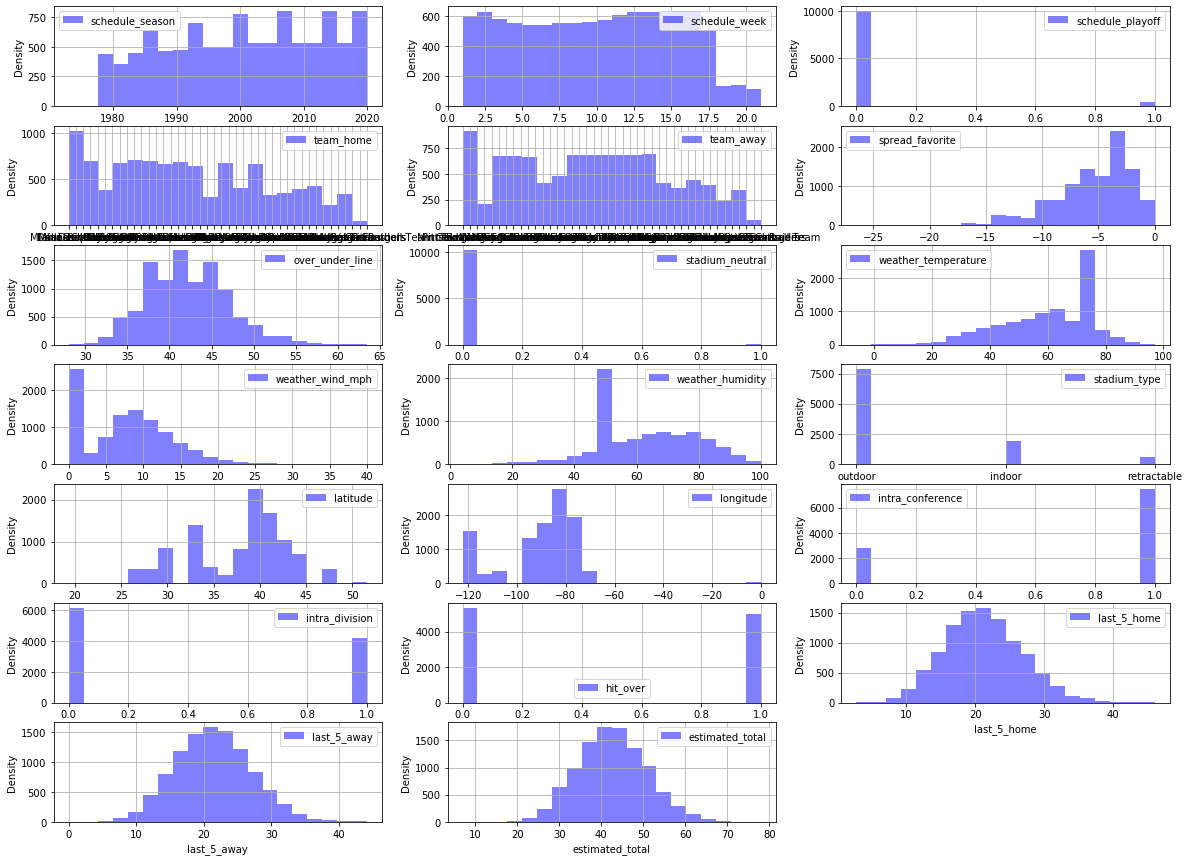

In [126]:
#Check for normalcy
histogram_view(new_nfl)

* Overall the data looks very normal and should be a great starting point for regression

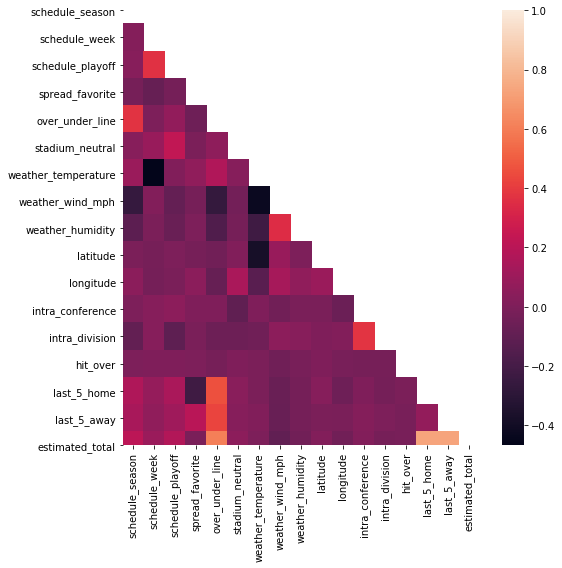

In [127]:
# Now how about multicolinearity
plt.figure(figsize=(8,8))
matrix = np.triu(new_nfl.corr())
sns.heatmap(new_nfl.corr(), mask=matrix)
plt.show()

There are a lot of variables that appear to have a similar level of correlation in the middle of this correlation matrix, but we can really dig into this by pulling up a Variance Inflation Factor

In [128]:
#Calculating VIF to review multicolinearity 
VIF_cols = []
for c in new_nfl.columns:
    if new_nfl[c].dtype in ['float64', 'int64', 'int32']:
        VIF_cols.append(c)
vif = pd.DataFrame()
X = new_nfl[VIF_cols].dropna()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif)

           variables         VIF
0    schedule_season  335.896910
1      schedule_week    6.841824
2   schedule_playoff    1.241090
3    spread_favorite    3.910372
4    over_under_line  146.000099
..               ...         ...
12    intra_division    2.086455
13          hit_over    1.955315
14       last_5_home         inf
15       last_5_away         inf
16   estimated_total         inf

[17 rows x 2 columns]


/Users/matthewnykaza/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


* In general anything above 10 is considered to be high correlation, and just on a brief view it is clear that we have some extraordinaily high correlations going on here. 
* This gives some credence to the idea we will need to use a model (i.e. Tree Based) that does not care about multicolinearity

In [129]:
#Look into object cols
new_nfl[[c for c in new_nfl.columns if new_nfl[c].dtype == 'object']].describe()

,team_home,team_away,stadium_type
count,10361,10361,10361
unique,42,42,3
top,New England Patriots,Green Bay Packers,outdoor
freq,362,350,7866


In [130]:
#going to to test train splits a little differently, as we want to test on the most recent data as this is likely
# what we will be doing in the future
#We are going to used the last 5 seasons of data 2016-2020 as based ont schedule season for our test, this is a tad
#small, but we can try and change this later if we find it is too small
# and we'll define X and y in this step
train = new_nfl[(new_nfl['schedule_season'] < 2016)]
test = new_nfl[(new_nfl['schedule_season'] >= 2016)]
y_train = train['hit_over']
y_test = test['hit_over']
X_train = train.drop(columns=['hit_over'])
X_test = test.drop(columns=['hit_over'])

In [131]:
#Check to make sure indicies look right for train and test
y_train.head()

6     0
8     1
9     1
11    1
16    0
Name: hit_over, dtype: int64

In [132]:
X_train.head()

,schedule_season,schedule_week,schedule_playoff,team_home,team_away,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,intra_conference,intra_division,last_5_home,last_5_away,estimated_total
6,1973,21,1,Miami Dolphins,Minnesota Vikings,-6.5,33.0,1,47.0,7.0,81.0,outdoor,29.716341,-95.409662,0,0,8.500000,7.0,15.500000
8,1975,21,1,Dallas Cowboys,Pittsburgh Steelers,-7.0,36.0,1,49.0,18.0,44.0,outdoor,25.776346,-80.219909,0,0,18.500000,16.0,34.500000
9,1976,21,1,Minnesota Vikings,Oakland Raiders,-4.0,38.0,1,52.0,6.0,59.0,outdoor,34.163214,-118.165789,0,0,6.666667,14.0,20.666667
11,1978,21,1,Dallas Cowboys,Pittsburgh Steelers,-3.5,37.0,1,71.0,18.0,84.0,outdoor,25.776346,-80.219909,0,0,20.250000,18.5,38.750000
16,1979,1,0,Kansas City Chiefs,Baltimore Colts,-1.0,37.0,0,76.0,8.0,71.0,outdoor,39.048939,-94.483984,1,0,23.000000,11.5,34.500000


In [133]:
y_test.head()

9059    1
9060    0
9061    1
9062    0
9063    0
Name: hit_over, dtype: int64

In [134]:
X_test.head()

,schedule_season,schedule_week,schedule_playoff,team_home,team_away,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,stadium_type,latitude,longitude,intra_conference,intra_division,last_5_home,last_5_away,estimated_total
9059,2016,1,0,Denver Broncos,Carolina Panthers,-3.0,40.5,0,82.0,2.0,NaN,outdoor,39.743952,-105.019223,0,0,22.8,28.2,51.0
9060,2016,1,0,Arizona Cardinals,New England Patriots,-8.5,44.0,0,72.0,0.0,NaN,retractable,33.529115,-112.264563,0,0,25.0,21.6,46.6
9061,2016,1,0,Atlanta Falcons,Tampa Bay Buccaneers,-2.5,47.0,0,72.0,0.0,50.0,indoor,33.757577,-84.400952,1,1,15.8,18.8,34.6
9062,2016,1,0,Baltimore Ravens,Buffalo Bills,-3.0,44.5,0,82.0,7.0,NaN,outdoor,39.277966,-76.623809,1,0,13.8,22.6,36.4
9063,2016,1,0,Dallas Cowboys,New York Giants,-1.0,47.5,0,72.0,0.0,NaN,retractable,32.752953,-97.087837,1,1,14.2,26.6,40.8


All looks solid for this point, time to get to modeling.

# Modeling 

In [135]:
# Look at some basic information about how we might want to set up our pipeline for the following steps

num_cols = []
ohe_cols = []
freq_cols = []
    
for c in X_train.columns:
    if new_nfl[c].dtype in ['float64', 'int64', 'int32']:
        num_cols.append(c)
    elif len(X_train[c].unique()) <= 15:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [136]:
# Check our work
print(f"Numeric: {num_cols}")
print(f"To OHE: {ohe_cols}")
print(f"To Frequency Encode: {freq_cols}")

Numeric: ['schedule_season', 'schedule_week', 'schedule_playoff', 'spread_favorite', 'over_under_line', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'latitude', 'longitude', 'intra_conference', 'intra_division', 'last_5_home', 'last_5_away', 'estimated_total']
To OHE: ['stadium_type']
To Frequency Encode: ['team_home', 'team_away']


* I even might just want to OHE the home and away team names, but I also might just get rid of these all together as I have some concerns about how teams change over time and I don't want the model relying on how a team performed in 1979, just to learn trends in the data
* I think it makes sense to OHE the stadium type, but if this gives me issues later I can also make them 0=outdoors, 1=indoors and 3=retractable, but I am worried as retracable is really kinda both of the other two

In [137]:
#Check vs. test to make sure there are not any issues
num_cols_test = []
ohe_cols_test = []
freq_cols_test = []
    
for c in X_test.columns:
    if new_nfl[c].dtype in ['float64', 'int64', 'int32']:
        num_cols_test.append(c)
    elif len(X_test[c].unique()) <= 15:
        ohe_cols_test.append(c)
    else:
        freq_cols_test.append(c)

In [138]:
# Check our work
print(f"Numeric: {num_cols_test}")
print(f"To OHE: {ohe_cols_test}")
print(f"To Frequency Encode: {freq_cols_test}")

Numeric: ['schedule_season', 'schedule_week', 'schedule_playoff', 'spread_favorite', 'over_under_line', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'latitude', 'longitude', 'intra_conference', 'intra_division', 'last_5_home', 'last_5_away', 'estimated_total']
To OHE: ['stadium_type']
To Frequency Encode: ['team_home', 'team_away']


### Setting up preprocessing
* Numerical Data
* * Since (as seen in the histograms) there do not seem to be many major outliers present in the data I am simply going to use a Min-Max scaler to get all the data on the same range
* * For the imputer I am going to start with the median, there really isn't that much a difference than the mean here so I doubt that it will have much of an impact on the model
* Categorical Data
* * Nothing too crazy here, only have the one column of stadium_type, so this should be straighforward encoding
* * May later on try the home and away teams here, but the more I think about it, the more likely it is that I will drop them.
* Frequency Data
* * As stated before I very well may drop the teams, just going to encode for now with the Count Encoder 

In [139]:
X_train.describe()

,schedule_season,schedule_week,schedule_playoff,spread_favorite,over_under_line,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,latitude,longitude,intra_conference,intra_division,last_5_home,last_5_away,estimated_total
count,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,8782.000000,8782.000000,7987.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000,9027.000000
mean,1997.961560,9.433920,0.036889,-5.389110,41.537244,0.007422,59.496242,7.578684,62.970702,37.869576,-90.412566,0.726598,0.411322,20.968960,21.256065,42.225025
std,10.541066,5.179595,0.188501,3.426065,4.541411,0.085837,15.322526,5.731902,15.751996,5.239067,15.547006,0.445730,0.492101,5.601384,5.591866,8.158079
min,1973.000000,1.000000,0.000000,-26.500000,28.000000,0.000000,-6.000000,0.000000,4.000000,19.303062,-122.389227,0.000000,0.000000,2.800000,0.000000,7.000000
25%,1989.000000,5.000000,0.000000,-7.000000,38.000000,0.000000,49.000000,2.000000,50.000000,33.741551,-95.407756,0.000000,0.000000,17.000000,17.400000,36.400000
50%,1998.000000,10.000000,0.000000,-4.500000,41.000000,0.000000,63.000000,8.000000,62.000000,39.098319,-86.164062,1.000000,0.000000,20.800000,21.000000,42.000000
75%,2007.000000,14.000000,0.000000,-3.000000,44.500000,0.000000,72.000000,11.000000,75.000000,41.470564,-80.014015,1.000000,1.000000,24.600000,25.000000,47.600000
max,2015.000000,21.000000,1.000000,0.000000,63.000000,1.000000,95.000000,40.000000,100.000000,51.553155,-0.295756,1.000000,1.000000,46.000000,44.200000,78.000000


In [140]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9027 entries, 6 to 9058
Data columns (total 19 columns):
schedule_season        9027 non-null int64
schedule_week          9027 non-null int32
schedule_playoff       9027 non-null int64
team_home              9027 non-null object
team_away              9027 non-null object
spread_favorite        9027 non-null float64
over_under_line        9027 non-null float64
stadium_neutral        9027 non-null int64
weather_temperature    8782 non-null float64
weather_wind_mph       8782 non-null float64
weather_humidity       7987 non-null float64
stadium_type           9027 non-null object
latitude               9027 non-null float64
longitude              9027 non-null float64
intra_conference       9027 non-null int64
intra_division         9027 non-null int64
last_5_home            9027 non-null float64
last_5_away            9027 non-null float64
estimated_total        9027 non-null float64
dtypes: float64(10), int32(1), int64(5), object(3)
me

In [141]:
# Now, set up the preprocessing steps for each type of col
num_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

ohe_transformer = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])

freq_transformer = Pipeline(steps=[
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('freq_enc', ce.CountEncoder(normalize=True,
                                 handle_unknown=0,
                                 min_group_size=0.001,
                                 min_group_name='Other'))])

In [142]:
# Put together our preprocessor using a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols), 
        ('cat_freq', freq_transformer, freq_cols)])

In [143]:
#Check work
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9027 entries, 6 to 9058
Data columns (total 19 columns):
schedule_season        9027 non-null int64
schedule_week          9027 non-null int32
schedule_playoff       9027 non-null int64
team_home              9027 non-null object
team_away              9027 non-null object
spread_favorite        9027 non-null float64
over_under_line        9027 non-null float64
stadium_neutral        9027 non-null int64
weather_temperature    8782 non-null float64
weather_wind_mph       8782 non-null float64
weather_humidity       7987 non-null float64
stadium_type           9027 non-null object
latitude               9027 non-null float64
longitude              9027 non-null float64
intra_conference       9027 non-null int64
intra_division         9027 non-null int64
last_5_home            9027 non-null float64
last_5_away            9027 non-null float64
estimated_total        9027 non-null float64
dtypes: float64(10), int32(1), int64(5), object(3)
me

In [144]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced', random_state=42))])

clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['schedule_season',
                                                   'schedule_week',
                                                   'schedule_playoff',
                                                   'spread_favorite',
                                                   'over_under_line',
                                                   'stadium_neutral',
                                                   'weather_temperature',
                                                   'weather_wind_mph',

In [145]:
# This is just a nice little bit of code that will give us relevant test results of our model!
def evaluate(estimator, X_train, X_test, y_train, y_test, use_decision_function='yes'):
    '''
    Evaluation function to show a few scores for both the train and test set
    Also shows a confusion matrix for the test set
    
    use_decision_function allows you to toggle whether you use decision_function or
    predict_proba in order to get the output needed for roc_auc_score
    If use_decision_function == 'skip', then it ignores calculating the roc_auc_score
    
    Additionally for models that have a decision function this model will show a ROC Curve
    '''
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # output needed for roc_auc_score
    if use_decision_function == 'skip': # skips calculating the roc_auc_score
        train_out = False
        test_out = False
    elif use_decision_function == 'yes': # not all classifiers have decision_function
        train_out = estimator.decision_function(X_train)
        test_out = estimator.decision_function(X_test)
    elif use_decision_function == 'no':
        train_out = estimator.predict_proba(X_train)[:, 1] # proba for the 1 class
        test_out = estimator.predict_proba(X_test)[:, 1]
    else:
        raise Exception ("The value for use_decision_function should be 'skip', 'yes' or 'no'.")

    print(type(test_out))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds)}")
    if type(train_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_train, train_out)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds)}")
    if type(test_out) == np.ndarray:
        print(f"ROC-AUC: {roc_auc_score(y_test, test_out)}")
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test)
    plt.show()
    
    #Plot ROC Curve
    if use_decision_function == 'yes':
        y_train_score = estimator.decision_function(X_train)
        y_test_score = estimator.decision_function(X_test)

        train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
        test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

        print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
        print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))

        plt.figure(figsize=(10, 8))
        lw = 2

        plt.plot(train_fpr, train_tpr, color='blue',
                 lw=lw, label='Train ROC curve')
        plt.plot(test_fpr, test_tpr, color='darkorange',
                 lw=lw, label='Test ROC curve')

        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
    else:
        None

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.5324027916251246
F1 Score: 0.5264220801077079
ROC-AUC: 0.541678799685634
--------------------
Test Scores
-----------
Accuracy: 0.5112443778110944
F1 Score: 0.4493243243243243
ROC-AUC: 0.5229588163294694


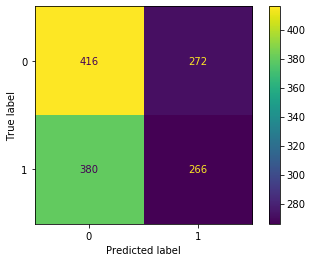

Train AUC: 0.541678799685634
Test AUC: 0.5229588163294694


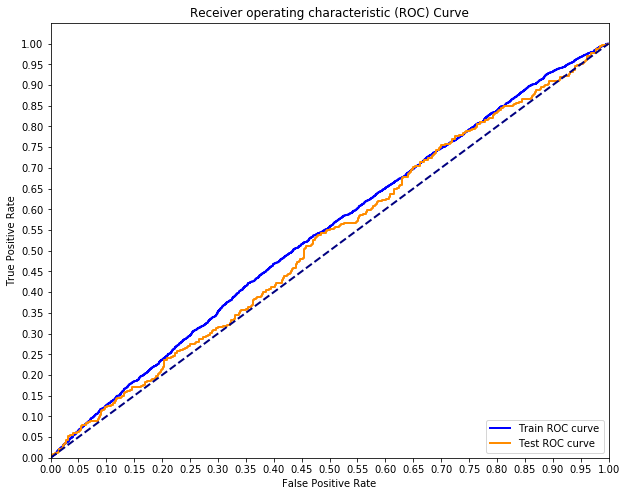

In [146]:
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

## Some Takeaways
* Slightly better than a guess
* The confusion matrix shows that we are best at telling when a game is going to be 'under'
* ROC curve indicates that we are essentially guessing with this model


## Let's take teams out and see what happens???

In [147]:
#Remove team names from the data
no_team_names = new_nfl.copy().drop(columns=['team_home', 'team_away'])
train = no_team_names[(no_team_names['schedule_season'] < 2016)]
test = no_team_names[(no_team_names['schedule_season'] >= 2016)]
y_train = train['hit_over']
y_test = test['hit_over']
X_train = train.drop(columns=['hit_over'])
X_test = test.drop(columns=['hit_over'])

In [148]:
#Need to run these again
num_cols = []
ohe_cols = []
freq_cols = []
    
for c in X_train.columns:
    if no_team_names[c].dtype in ['float64', 'int64', 'int32']:
        num_cols.append(c)
    elif len(X_train[c].unique()) <= 15:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [149]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat_ohe', ohe_transformer, ohe_cols)])

In [150]:

print(f"Numeric: {num_cols}")
print(f"To OHE: {ohe_cols}")
print(f"To Frequency Encode: {freq_cols}")

Numeric: ['schedule_season', 'schedule_week', 'schedule_playoff', 'spread_favorite', 'over_under_line', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'latitude', 'longitude', 'intra_conference', 'intra_division', 'last_5_home', 'last_5_away', 'estimated_total']
To OHE: ['stadium_type']
To Frequency Encode: []


In [151]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', LogisticRegression(class_weight='balanced', random_state=42))])
clf_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['schedule_season',
                                                   'schedule_week',
                                                   'schedule_playoff',
                                                   'spread_favorite',
                                                   'over_under_line',
                                                   'stadium_neutral',
                                                   'weather_temperature',
                                                   'weather_wind_mph',

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.5324027916251246
F1 Score: 0.5266345183357631
ROC-AUC: 0.5416435185207935
--------------------
Test Scores
-----------
Accuracy: 0.5112443778110944
F1 Score: 0.44651952461799665
ROC-AUC: 0.523093815249478


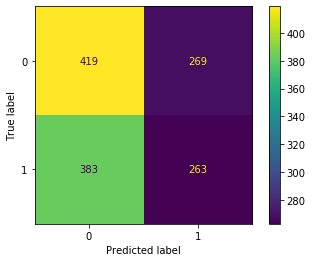

Train AUC: 0.5416435185207935
Test AUC: 0.523093815249478


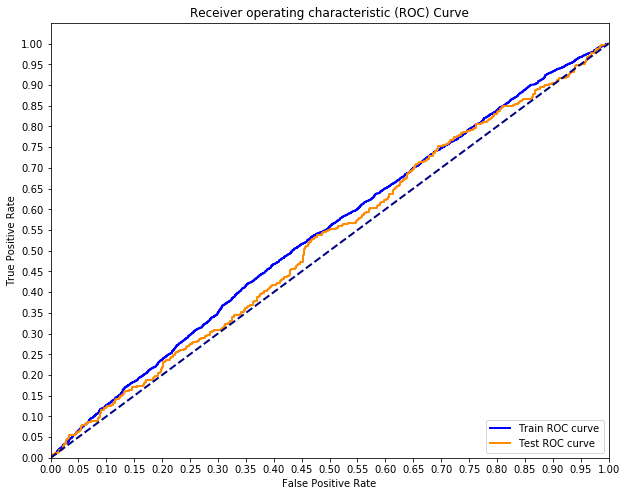

In [152]:
evaluate(clf_logreg, X_train, X_test, y_train, y_test)

## Some Takeaways
* Overall it does not appear to have made much of a difference
* We may be ever so slightly overfit, but not any more so than what we were before
* It is clear that a basic Logistic Regression is not the answer
* * This is likely because there is a whole lot of multicolinearity in the data, so I believe it will be best to use a Tree based model as this will negate any multicollinearity

# Tree Based Models

In [153]:
tree_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))])
tree_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['schedule_season',
                                                   'schedule_week',
                                                   'schedule_playoff',
                                                   'spread_favorite',
                                                   'over_under_line',
                                                   'stadium_neutral',
                                                   'weather_temperature',
                                                   'weather_wind_mph',

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.49025487256371814
F1 Score: 0.4670846394984326
ROC-AUC: 0.48937108503131976


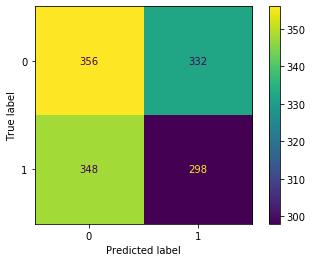

In [154]:
evaluate(tree_logreg, X_train, X_test, y_train, y_test, use_decision_function='no')

## Some Takeaways
* Scores are largely unchanged in the grand scheme of things here, but with some hyperparameter tuning I believe that we can get a solid score
* Current goal is to get in the 60 range for all scores

In [155]:
#Let's use GridsearchCV 
param_grid = {
    'classifier__max_depth': [x for x in range(4,12,2)],
    'classifier__min_samples_split': [x for x in range(4, 12, 2)],
    'classifier__max_features': [ 'log2'],
    'classifier__min_samples_leaf': [x for x in range(10, 20, 2)],
    
}

In [156]:
griddy = GridSearchCV(tree_logreg, param_grid, n_jobs=1, cv=3)

In [157]:
griddy.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['schedule_season',
                                                                          'schedule_week',
                                                                          'schedule_playoff',
                                                                          'spread_favorite',
                                   

In [158]:
print(f"Best parameter's score: {griddy.best_score_:0.3f}):")
print(griddy.best_params_)

Best parameter's score: 0.521):
{'classifier__max_depth': 8, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 14, 'classifier__min_samples_split': 4}


<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.5624238395923341
F1 Score: 0.47529224229543043
ROC-AUC: 0.5956151261262331
--------------------
Test Scores
-----------
Accuracy: 0.5269865067466267
F1 Score: 0.44109831709477415
ROC-AUC: 0.5279222766217871


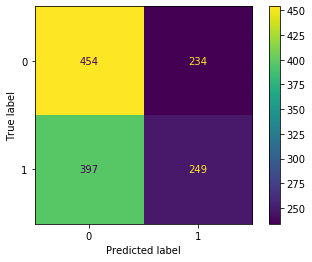

In [159]:
evaluate(griddy.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

## On the Hyperparameters
* criterion - from what I could find, either way the model performed about the same, so I am not concerned with this
* splitter - similar takeaway as criterion
* max_depth - with nothing set the tree will be perfect on the training set, but not generalize well on test set. Through some testing I found that a depth of somewhere around 4 was often best, although this seemed a bit small to me
* min_samples_split - looked like 4 was very consistently the best number here, higher numbers tend to introduce under-fitting, so I think 4 was a good number, and that's what the data told us
* min_samples_leaf- is similar to min_samples_split, but when used togther they can help us make sure that the tree isn't using 1 sample to make a decision
* max_features - mostly helps with computational time, so I really went with allowing the model to determine what is best, as I am not too concerned with the length of time this can take
* max_leaf_nodes - ran this a few times and it appeared that haveing a number around 80 was bst for this metric, although none of this improved the model to any great degree, and really this parameter seemed best when I left it alone.

## Some Takeaways
* The results largely improved, with the exception of F1 score on the test set, this is not a great development as the lower f1 score (combined with greater accuracy) shows that we had poor recall
* Seems like this was better at selecting overs (1), but may have just erred that way too often
* It seems that through pruning I am mostly getting trees that err one way or the other, but not really improving greatly on their overall scores


# One last model, Random Forrests
This will be an ensemble model that ideally will be the most powerful

In [162]:
forest = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])
forest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['schedule_season',
                                                   'schedule_week',
                                                   'schedule_playoff',
                                                   'spread_favorite',
                                                   'over_under_line',
                                                   'stadium_neutral',
                                                   'weather_temperature',
                                                   'weather_wind_mph',

<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 1.0
F1 Score: 1.0
ROC-AUC: 1.0
--------------------
Test Scores
-----------
Accuracy: 0.525487256371814
F1 Score: 0.4373333333333333
ROC-AUC: 0.5209315825473395


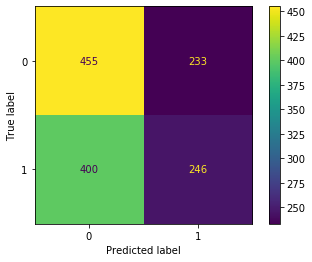

In [163]:
evaluate(forest, X_train, X_test, y_train, y_test, use_decision_function='no')

## Some Takeaways
* The model is picking the under (0) far to often, seemingly the opposite of our last model
* On a whole the scores did not improve much, over the DecisionTree with hyperparameter selection

In [164]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [165]:
random_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf,
               'classifier__bootstrap': bootstrap}
print(random_grid)


{'classifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'classifier__max_features': ['auto', 'sqrt'], 'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'classifier__min_samples_split': [2, 5, 10], 'classifier__min_samples_leaf': [1, 2, 4], 'classifier__bootstrap': [True, False]}


In [166]:
forest = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))])
forest.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['schedule_season',
                                                   'schedule_week',
                                                   'schedule_playoff',
                                                   'spread_favorite',
                                                   'over_under_line',
                                                   'stadium_neutral',
                                                   'weather_temperature',
                                                   'weather_wind_mph',

In [167]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune


# Random search of parameters, using 3 fold cross validation, 
# search across 20 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['schedule_season',
                                                                                'schedule_week',
                                                                                'schedule_playoff',
                                                                    

In [168]:
#This will give us a good baseline as to where to start our GridsearchCV process
rf_random.best_params_

{'classifier__n_estimators': 200,
 'classifier__min_samples_split': 2,
 'classifier__min_samples_leaf': 1,
 'classifier__max_features': 'auto',
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [169]:
#Utilized those paramaters to narrow down on GridSearchCV
param_grid = {'classifier__n_estimators': [150, 200, 250],
               'classifier__max_features': ['auto'],
               'classifier__max_depth': [110, 120, 140],
               'classifier__min_samples_split': [4, 5, 6],
               'classifier__min_samples_leaf': [3, 4, 5],
               'classifier__bootstrap': [True]}

In [170]:
griddy_2 = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=1, cv=3)

In [171]:
griddy_2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['schedule_season',
                                                                          'schedule_week',
                                                                          'schedule_playoff',
                                                                          'spread_favorite',
                                   

In [172]:
print(f"Best parameter's score: {griddy_2.best_score_:0.3f}):")
print(griddy_2.best_params_)

Best parameter's score: 0.521):
{'classifier__bootstrap': True, 'classifier__max_depth': 110, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 150}


<class 'numpy.ndarray'>
Train Scores
------------
Accuracy: 0.9996676636756398
F1 Score: 0.9996567112941984
ROC-AUC: 0.9999885999578788
--------------------
Test Scores
-----------
Accuracy: 0.5352323838080959
F1 Score: 0.45035460992907805
ROC-AUC: 0.5317247462020304


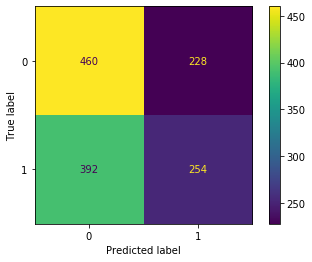

In [173]:
evaluate(griddy_2.best_estimator_, X_train, X_test, y_train, y_test, use_decision_function='no')

## Conclusion 
* This model was able to perform the best out of all previous models, and I really think that finding RancomizerCV as a method of getting a good starting point with the hyperparameters 
* All metrics rose by around .01 - .015 points, which may not seem like a lot, but this was the greatest increase in the data seen to date.
* Overall what this shows is the need to complete more data cleaning, and get more data. 
* I believe that one major issue is that I am trying to beat Las Vegas, which creates these point spreads using models much more advanced and practiced than this, I do believe that with more time this could be a viable product
* It may be that I have too much past data, when they game was very different, this could be a hinderence as well

## Further Work
* Need to get more information about each individual game, this could include more data mining and more feature engineering of feature variables
* More tests of Hyperparameters
    * Utilize graphing techniques to help determine some of these features
* Try boost models
    * They tend to be more powerful, and may be able to achieve better scores